In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import sys
from flowFieldWavy import *
from flowFieldArray import *
from pseudo import *
from laminar import *
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

#figureFolder = '/home/sabarish/Dropbox/reports/2016/JFM/figures/'
figureFolder = 'thesisFigures'




# Refining solutions

In [3]:
loadPath = 'solutions/Re1000/'
savePath = 'solutions/Re1000HighRes/'
files = os.listdir(loadPath)
files.sort()

logFile = open('laminarLogRe1000.txt','a',1)
orig_stdout = sys.stdout
sys.stdout = logFile
sys.stderr = logFile


In [7]:
for f in files[-3::-1]:
    vf, pf = loadff(loadPath+f)
    vf = vf.slice(L=10,N=80)
    pf = pf.slice(L=10,N=80)
    vf[0,:,:,:,[0,-1]]=0.
    vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax = 4,tol = 1.0e-10)
    saveff(vf,pf, prefix=savePath)
    sys.stdout.flush()

KeyboardInterrupt: 

In [6]:
files[-3]

'T00E1000Gx1400Gz0000Re1000L08M00N50.npy'

In [ ]:
# Exact solutions to compare with low wavenumber analytical solution

flowDict = getDefaultDict()
Re = 100.
flowDict.update({'eps':0.005,'alpha':1.,'beta':0.,'Re':Re,'L':5,'M':0,'N':30,'nd':4, 'isPois':1})

savePath = 'solutions/Re0p1/'
epsArr = 0.5*np.arange(0.025,0.152,0.025)
aArr = 10.**(np.arange(-2.,1.01,0.2))

vfListRe100 = []; pfListRe100 = []; fnormListRe100 = []; flagListRe100 = []
flowDict.update({'eps':np.float(epsArr[0]),'alpha':np.float(aArr[0])})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()
start = time.time()
for eps in epsArr:
    vf.flowDict.update({'eps':np.float(eps)})
    pf.flowDict.update({'eps':np.float(eps)})
    for a in aArr:
        vf.flowDict.update({'alpha':np.float(a)})
        pf.flowDict.update({'alpha':np.float(a)})
        
        start1 = time.time()
        print('eps:%f, a:%f, gx:%f, Re:%f'%(eps,a,eps*a,vf.flowDict['Re']))
        vf,pf,fnormArr,flg = iterate(vf=vf, pf=pf,tol=1.0e-12)
        vfListRe100.append(vf.copy())
        pfListRe100.append(pf.copy())
        fnormListRe100.append(fnormArr.copy())
        flagListRe100.append(flg)
        
        print('Runtime:', int(time.time()-start1), ',  total time elapsed:',int(time.time()-start))
        print('**************************************')

In [3]:
# Loading solution files for amplitude-slope parametric range at Re of either 10, 100, or 1000
Re = 100.
loadPath = 'solutions/Re'+ str(int(Re))+'/'
files= [f for f in os.listdir(loadPath)]
files.sort()

epsArr = np.zeros((20,30)).flatten()
aArr = epsArr.copy()
gArr = epsArr.copy()
vList = []; pList = []
k = 0
for f in files:
    vf,pf = loadff(loadPath+f)
    vList.append(vf); pList.append(pf)
    eps = vf.flowDict['eps']
    a = vf.flowDict['alpha']
    g = eps*a
    epsArr[k] = eps
    gArr[k] = g
    aArr[k] = a
    k+= 1
    
epsArr = epsArr.reshape((20,30))
gArr= gArr.reshape((20,30))

neps = epsArr.shape[0]; ng = epsArr.shape[1]; nRe = 1
vArr = flowFieldArray(vList,neps,ng,nRe); pArr = flowFieldArray(pList,neps,ng,nRe)

FileNotFoundError: [Errno 2] No such file or directory: 'solutions/Re100/'

In [18]:
# Calculating vCL_RMS, xSep, xReat, yBub, vFlux, and pDrag for each flowField in vArr,pArr
pDrag = np.zeros(epsArr.shape)
xSep = pDrag.copy(); xReat = pDrag.copy(); xBub = pDrag.copy(); yBub = pDrag.copy()
vFlux = pDrag.copy()
vCore = pDrag.copy()

for k1 in range(neps):
    for k2 in range(ng):
        vf = vArr[k1,k2,0].field
        pf = pArr[k1,k2,0].field
        pDrag[k1,k2] = presDrag(pf)[0]
        shearDict = shearStress(vf, seprn=True)
        xSep[k1,k2] = shearDict['xSep']
        xReat[k1,k2] = shearDict['xReat']
        yBub[k1,k2] = shearDict['yBub']
        if xSep[k1,k2] is not None:
            xBub[k1,k2] = xReat[k1,k2] - xSep[k1,k2]
        else:
            xBub[k1,k2] = None
        
        vFlux[k1,k2] = vf.flux()
        vCore[k1,k2] = vCL_RMS(vf)


epsVec = epsArr[:,0]; gVec = gArr[0,:]   

In [19]:
xSep[np.isnan(xSep)] = 0.50001
xReat[np.isnan(xReat)] = 0.49999
yBub[np.isnan(yBub)] = -0.00001
xBub = xReat - xSep


vArrRe100 = vArr.copy(); pArrRe100 = pArr.copy()
pDragRe100 = pDrag.copy(); vFluxRe100 = vFlux.copy(); vCoreRe100 = vCore.copy()
xSepRe100 = xSep.copy(); xReatRe100 = xReat.copy(); xBubRe100 = xBub.copy(); yBubRe100 = yBub.copy()

In [20]:
epsArr = 0.5*np.arange(0.01,0.2001,0.01)
gArr = 0.5*np.arange(0.1,3.001,0.1)
epsArr = np.tile(epsArr.reshape(20,1),(1,30))
gArr = np.tile(gArr.reshape(1,30),(20,1))

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


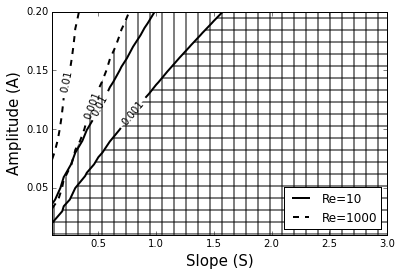

In [60]:
plt.figure()
# vCore
vCoreLevels= [0.001,0.01]
C10 = plt.contour(2.*gArr, 2.*epsArr, vCoreRe10,levels=vCoreLevels,colors='k',linewidths=2)
C10hatch = plt.contourf(2.*gArr, 2.*epsArr, vCoreRe10,levels=[0.,0.001],hatches=['-'],colors='none')
plt.clabel(C10,fmt='%0.4g',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, vCoreRe1000, levels=vCoreLevels, colors='k',linestyles='dashed',linewidths=2)
C1000hatch = plt.contourf(2.*gArr, 2.*epsArr, vCoreRe1000,levels=[0.,0.001],hatches=['|'],colors='none')
plt.clabel(C1000,fmt='%0.4g',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')

plt.savefig(figureFolder+'noLabels/'+"vCore.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"vCore.eps",dpi=600,format="eps")
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


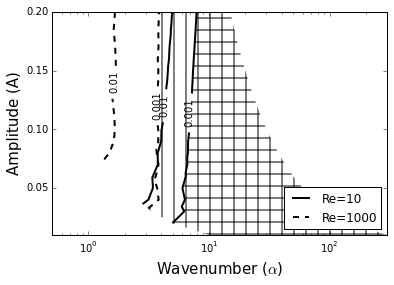

In [61]:
fName = "vCoreAlpha.eps"
plt.figure()
# vCore
vCoreLevels= [0.001,0.01]
C10 = plt.contour(gArr/epsArr, 2.*epsArr, vCoreRe10,levels=vCoreLevels,colors='k',linewidths=2)
C10hatch = plt.contourf(gArr/epsArr, 2.*epsArr, vCoreRe10,levels=[0.,0.001],hatches=['-'],colors='none')
plt.clabel(C10,fmt='%0.4g',fontsize='x-large')
C1000 = plt.contour(gArr/epsArr, 2.*epsArr, vCoreRe1000, levels=vCoreLevels, colors='k',linestyles='dashed',linewidths=2)
C1000hatch = plt.contourf(gArr/epsArr, 2.*epsArr, vCoreRe1000,levels=[0.,0.001],hatches=['|'],colors='none')
plt.clabel(C1000,fmt='%0.4g',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')
plt.xscale("log")

plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format="eps")
plt.xlabel("Wavenumber ($\\alpha$)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format="eps")
plt.show()

In [21]:
plt.figure()
# vFlux
vFluxLevels = 1./3.*np.arange(1.0,2.1,0.2)
C10 = plt.contour(2.*gArr, 2.*epsArr, vFluxRe10,levels=vFluxLevels,colors='k')
plt.clabel(C10,fmt='%0.3f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, vFluxRe1000, levels=vFluxLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.3f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"vFlux.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"vFlux.eps",dpi=600,format="eps")
plt.show()

plt.figure()
#pDrag
pDragLevels = np.arange(0.2,0.85,0.2)
C10 = plt.contour(2.*gArr, 2.*epsArr, pDragRe10,levels=pDragLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, pDragRe1000,levels=pDragLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='center right')
plt.savefig(figureFolder+'noLabels/'+"pDrag.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"pDrag.eps",dpi=600,format="eps")
plt.show()



plt.figure()
# xSep
xSepLevels = np.arange(0.1,0.55,0.1)
C10 = plt.contour(2.*gArr, 2.*epsArr, xSepRe10,levels=xSepLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, xSepRe1000,levels=xSepLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='upper right')
plt.savefig(figureFolder+'noLabels/'+"xSep.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"xSep.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# xReat
xReatLevels = np.arange(0.5,0.95,0.1)
C10 = plt.contour(2.*gArr, 2.*epsArr, xReatRe10,levels=xReatLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, xReatRe1000,levels=xReatLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='center right')
plt.savefig(figureFolder+'noLabels/'+"xReat.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"xReat.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# xBub
xBubLevels = np.arange(0.,1.1,0.2)
C10 = plt.contour(2.*gArr, 2.*epsArr, xBubRe10,levels=xBubLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, xBubRe1000,levels=xBubLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"xBub.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"xBub.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# yBub
yBubLevels = np.arange(0.,0.81,0.2)
C10 = plt.contour(2.*gArr, 2.*epsArr, yBubRe10,levels=yBubLevels, colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe1000,levels=yBubLevels,colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["Re=10", "Re=1000"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"yBub.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"yBub.eps",dpi=600,format="eps")
plt.show()


NameError: name 'vFluxRe10' is not defined

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


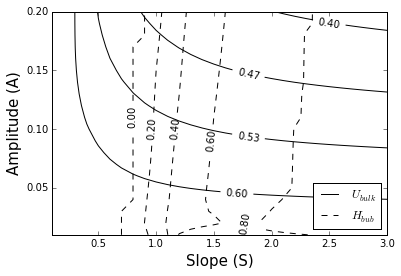

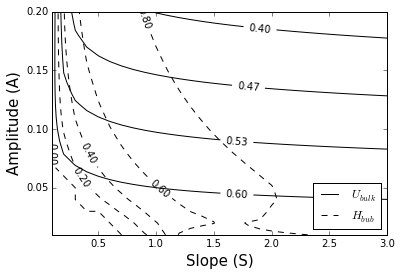

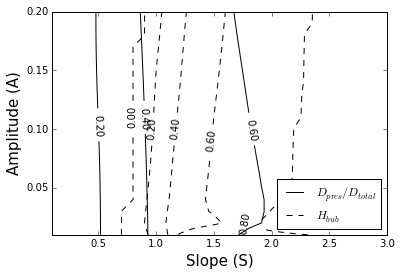

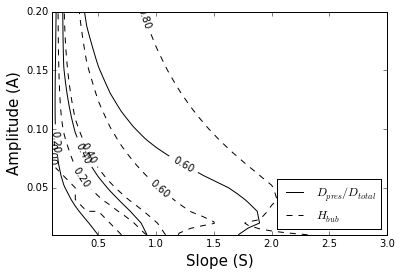

In [66]:
plt.figure()
# vFlux-yBub
C10 = plt.contour(2.*gArr, 2.*epsArr, vFluxRe10,levels=vFluxLevels,colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe10, levels=yBubLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["$U_{bulk}$", "$H_{bub}$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"vFluxYbubRe10.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"vFluxYbubRe10.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# vFlux-yBub
C10 = plt.contour(2.*gArr, 2.*epsArr, vFluxRe1000,levels=vFluxLevels,colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe1000, levels=yBubLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["$U_{bulk}$", "$H_{bub}$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"vFluxYbubRe1000.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"vFluxYbubRe1000.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# pDrag-yBub
C10 = plt.contour(2.*gArr, 2.*epsArr, pDragRe10,levels=pDragLevels,colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe10, levels=yBubLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["$D_{pres}/D_{total}$", "$H_{bub}$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"pDragYbubRe10.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"pDragYbubRe10.eps",dpi=600,format="eps")
plt.show()

plt.figure()
# pDrag-yBub
C10 = plt.contour(2.*gArr, 2.*epsArr, pDragRe1000,levels=pDragLevels,colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
C1000 = plt.contour(2.*gArr, 2.*epsArr, yBubRe1000, levels=yBubLevels, colors='k',linestyles='dashed')
plt.clabel(C1000,fmt='%0.2f',fontsize='x-large')
plt.legend([C10.collections[0],C1000.collections[0]],["$D_{pres}/D_{total}$", "$H_{bub}$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+"pDragYbubRe1000.eps",dpi=600,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+"pDragYbubRe1000.eps",dpi=600,format="eps")
plt.show()

In [26]:
xBub[:, 7:9]

array([[ 0.      ,  0.      ],
       [ 0.111642,  0.296109],
       [ 0.080471,  0.286238],
       [      nan,  0.274846],
       [      nan,  0.261341],
       [      nan,  0.246931],
       [      nan,  0.231825],
       [      nan,  0.216737],
       [      nan,  0.202403],
       [      nan,  0.189135],
       [      nan,  0.176853],
       [      nan,  0.165288],
       [      nan,  0.154093],
       [      nan,  0.142853],
       [      nan,  0.130988],
       [      nan,  0.11739 ],
       [      nan,  0.098051],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan]])

In [ ]:
flowDict = getDefaultDict()
flowDict.update({'K':0,'L':5,'M':0,'N':11,'Re':0.01,'alpha':0.01,'beta':0.,'eps':0.1,'isPois':1})

In [ ]:
vf,pf,fnormArr,flg = iterate(flowDict=flowDict, rect=False,tol = 1.0e-13,iterMax=10)

In [ ]:
vfAn = vf.zero()
a = vf.flowDict['alpha']; eps = vf.flowDict['eps']; g=eps*a
vfAn[0,vf.nx//2,0,0] = 1.-vfAn.y**2
vfAn[0,vf.nx//2+1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
vfAn[0,vf.nx//2+2,0,0] = 2.*g**2 * (1.-vfAn.y**2)
vfAn[0,vf.nx//2-1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
vfAn[0,vf.nx//2-2,0,0] = 2.*g**2 * (1.-vfAn.y**2)

vfAn[0,vf.nx//2,0,0] = 0.
vfAn[0,vf.nx//2+1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
vfAn[0,vf.nx//2+2,0,0] = 2.*g**2 * (1.-vfAn.y**2)
vfAn[0,vf.nx//2-1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
vfAn[0,vf.nx//2-2,0,0] = 2.*g**2 * (1.-vfAn.y**2)



In [ ]:
chebcoeffs(vf[0,vf.nx//2,0,0]),chebcoeffs(vf[0,vf.nx//2+1,0,0]),chebcoeffs(vf[0,vf.nx//2+2,0,0])

In [ ]:
chebcoeffs(vf[0,3,0,1]),chebcoeffs(vf[0,4,0,1]),chebcoeffs(vf[0,5,0,1])

In [ ]:
chebcoeffs(pf[0,3,0,0]),chebcoeffs(pf[0,4,0,0]),chebcoeffs(pf[0,5,0,0]), chebcoeffs(pf[0,2,0,0])

In [ ]:
pf[0,2,0,0,-1], pf[0,4,0,0,-1]

In [ ]:
flowDict = vf.flowDict.copy()
flowDict.update({'L':3,'M':0,'N':7,'Re':1.,'alpha':0.1,'beta':0.,'eps':0.01})

In [ ]:
vf,pf,fnormArr,flg = iterate(flowDict=flowDict, rect=False,tol = 1.0e-13,iterMax=10)

In [ ]:
chebcoeffs(vf[0,3,0,0]),chebcoeffs(vf[0,4,0,0]),chebcoeffs(vf[0,5,0,0])

In [ ]:
chebcoeffs(vf[0,3,0,1]),chebcoeffs(vf[0,4,0,1]),chebcoeffs(vf[0,5,0,1])

In [ ]:
chebcoeffs(pf[0,3,0,0]),chebcoeffs(pf[0,4,0,0]),chebcoeffs(pf[0,5,0,0])

In [ ]:
pf[0,5,0,0]

In [ ]:
flowDict = vf.flowDict.copy()
flowDict.update({'L':6,'M':0,'N':35,'Re':10.,'alpha':10.,'beta':0.,'eps':0.05})
vf,pf,fnormArr,flg = iterate(flowDict=flowDict, rect=False,tol = 1.0e-13,iterMax=10)

In [ ]:
(vf[0,8,0,0] - vf[0,8,0,0,::-1])

In [ ]:
w = clencurt(vf.N)
vf[0,vf.nx//2+2,0,0],np.dot(w,vf[0,vf.nx//2+2,0,0])

In [ ]:
vf.div()

In [ ]:
import os 
files= [f for f in os.listdir('./solutions/Re0p1/')]
files.sort()
loadPath = 'solutions/Re0p1/'

In [ ]:
neps = 20;ng=19;nRe=1
Re = 0.1
uDistArr = np.zeros(neps*ng)
pDistArr = uDistArr.copy()
n=0
for f in files:
    vf,pf = loadff(loadPath+f,checkNorm=False)

    vfAn = vf.zero(); pfAn = pf.zero()
    a = vf.flowDict['alpha']; eps = vf.flowDict['eps']; g=eps*a
    vfAn[0,vf.nx//2,0,0] = 1.-vfAn.y**2
    vfAn[0,vf.nx//2+1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
    vfAn[0,vf.nx//2-1,0,0] = vfAn[0,vf.nx//2+1,0,0]
    
    vfAn[0,vf.nx//2+1,0,1] = 1.j*g*(1.-vfAn.y*2)
    vfAn[0,vf.nx//2+2,0,1] = 2.j/3.*g**2*a*(vfAn.y**3 - vfAn.y)
    vfAn[0,vf.nx//2-1,0,1] = -vfAn[0,vf.nx//2+1,0,1]
    vfAn[0,vf.nx//2-2,0,1] = -vfAn[0,vf.nx//2+2,0,1]
    
    pfAn[0,pf.nx//2+1,0,0] = -2.j*g/Re*pfAn.y
    pfAn[0,pf.nx//2+2,0,0] = -2.j*g*a/Re
    pfAn[0,pf.nx//2-1,0,0] = -pfAn[0,pf.nx//2+1,0,0]
    pfAn[0,pf.nx//2-2,0,0] = -pfAn[0,pf.nx//2+2,0,0]
    
    uDistArr[n] = (vf-vfAn).norm()/vf.norm() 
    pDistArr[n] = (pf-pfAn).norm()/pf.norm()
    print(eps,a,uDistArr[n],pDistArr[n])
    n+= 1


In [ ]:
flowDict = getDefaultDict()
aArr = np.arange(0.005,0.052,0.005,dtype=np.float)
epsArr = np.arange(0.005,0.052,0.005)
Re = 0.1
flowDict.update({'eps':epsArr[0],'alpha':aArr[0],'beta':0.,'Re':Re,'L':5,'M':0,'N':20,'nd':4, 'isPois':1})
vf = dict2ff(flowDict); pf = vf.getScalar().zero()

neps = epsArr.size; na = aArr.size
uDistArr = np.zeros(neps*na); pDistArr = uDistArr.copy()

ind=0
for eps in epsArr:
    for a in aArr:
        vf.flowDict.update({'eps':eps,'alpha':a})
        pf.flowDict.update({'eps':eps,'alpha':a})
        g = eps*a
        
        vf, pf, fnormArr, flg = iterate(vf=vf,pf=pf,rect=False, tol=1.0e-12 )

        vfAn = vf.zero(); pfAn = pf.zero()
        vfAn[0,vf.nx//2,0,0] = 1.-vfAn.y**2
        vfAn[0,vf.nx//2+1,0,0] = 2./3.*g*a*(vfAn.y**3 - vfAn.y)
        vfAn[0,vf.nx//2-1,0,0] = vfAn[0,vf.nx//2+1,0,0]

        vfAn[0,vf.nx//2+1,0,1] = 1.j*g*(1.-vfAn.y*2)
        vfAn[0,vf.nx//2+2,0,1] = 2.j/3.*g**2*a*(vfAn.y**3 - vfAn.y)
        vfAn[0,vf.nx//2-1,0,1] = -vfAn[0,vf.nx//2+1,0,1]
        vfAn[0,vf.nx//2-2,0,1] = -vfAn[0,vf.nx//2+2,0,1]

        pfAn[0,pf.nx//2+1,0,0] = -2.j*g/Re*pfAn.y
        pfAn[0,pf.nx//2+2,0,0] = -2.j*g*a/Re
        pfAn[0,pf.nx//2-1,0,0] = -pfAn[0,pf.nx//2+1,0,0]
        pfAn[0,pf.nx//2-2,0,0] = -pfAn[0,pf.nx//2+2,0,0]

        uDistArr[ind] = (vf-vfAn).norm()/vf.norm() 
        pDistArr[ind] = (pf-pfAn).norm()/pf.norm()
        print(eps,a,uDistArr[ind],pDistArr[ind])        
        ind+=1



In [ ]:
flowDict = updateDict(vf.flowDict,{'L':6,'M':0,'N':50,'eps':0.02,'alpha':30.,'beta':0.,'Re':100.})
vf,pf,fnorm,flg = iterate(flowDict=flowDict,rect=False,tol=1.0e-12)


In [ ]:
vf.shape,pf.shape,vf.nz,pf.nz

In [ ]:
presDrag(pf)

In [ ]:
stressDict = shearStress(vf,seprn=True)

In [ ]:
presDrag(pf)[0] + stressDict['avgStressFraction']

In [ ]:
type(genArr[0]) == np.float

In [ ]:
plt.contourf(epsArr,aArr,np.log(uDistArr.reshape((neps,na))),cmap=plt.cm.bone ) 
plt.xticks(np.arange(0.01,0.055,0.01))
plt.yticks(np.arange(0.01,0.055,0.01))
plt.colorbar();plt.show()

In [ ]:
np.log(uDistArr)

In [ ]:
y = vf.y

In [ ]:
genFun = 1.*y**3 + 4.*y**2 + y  - y**4

In [ ]:
np.arange(y.size)[genFun<=0]

In [ ]:
genFun

## High wavenumber asymptote

In [ ]:
import sys
eps = 0.05; Re = 1000.
gArr = 0.5*np.arange(12.,19.9,1.)

aArr = gArr/eps
flowDict = getDefaultDict()
flowDict.update({'eps':eps,'beta':0.,'Re':Re,'isPois':1,'L':8,'M':0,'N':75,'nd':3})
flowDict.update({'alpha':aArr[0]})
vf = dict2ff(flowDict); pf = vf.getScalar().zero()
vfList = []; pfList=[]

for k in range(aArr.size):
    a = aArr[k] 
    vf.flowDict.update({'alpha':a}); pf.flowDict.update({'alpha':a}) 
    vf,pf,fnorm,flg = iterate(vf=vf,pf=pf,iterMax = 8,tol=5.0e-11)
    print('alpha:',a, '  flag:',flg)
    sys.stdout.flush()
    vfList.append(vf.copy())
    pfList.append(pf.copy())
    saveff(vf,pf,prefix='solutions/highAlpha/N75/')
    sys.stdout.flush()
    
    
    

In [ ]:
vfListRe1000 = vfList.copy(); pfListRe1000 = pfList.copy()

vfListRe10 = []; pfListRe10 = []

for k in range(len(vfList)):
    vf = vfList[k].copy(); pf = pfList[k].copy()
    vf.flowDict.update({'Re':10.}); pf.flowDict.update({'Re':10.})
    vf,pf,fnorm,flg = iterate(vf=vf,pf=pf,iterMax = 8,tol=1.0e-12)
    print('alpha:',vf.flowDict['alpha'], '  flag:',flg)
    sys.stdout.flush()
    vfListRe10.append(vf.copy())
    pfListRe10.append(pf.copy())
    saveff(vf,pf,prefix='solutions/highAlpha/')
    sys.stdout.flush()

In [72]:
vfListFine = []; pfListFine = []
loadPathFine = 'solutions/highAlpha/L08N75/'
files = os.listdir(loadPathFine)
files.sort()
for f in files:
    vf, pf = loadff(loadPathFine+f)
    vfListFine.append(vf.copy())
    pfListFine.append(pf.copy())
vfArrFine = flowFieldArray(vfListFine, 1,len(vfListFine),1)
pfArrFine = flowFieldArray(pfListFine, 1,len(vfListFine),1)

In [71]:
loadPath = 'solutions/highAlpha/'
files = os.listdir(loadPath)
files.sort()
vfList = []; pfList = []
for f in files:
    #print(loadPath+f)
    if not os.path.isdir(loadPath+f):
        vf,pf = loadff(loadPath+f)
        vfList.append(vf); pfList.append(pf)

vfArr = flowFieldArray(vfList, 1,len(vfList)//2,2)
pfArr = flowFieldArray(pfList, 1,len(pfList)//2,2)

In [73]:
vfListFiner = []; pfListFiner = []
loadPathFiner = 'solutions/highAlpha/L11N75/'
files = os.listdir(loadPathFiner)
files.sort()
for f in files:
    vf, pf = loadff(loadPathFiner+f)
    vfListFiner.append(vf.copy())
    pfListFiner.append(pf.copy())
vfArrFiner = flowFieldArray(vfListFiner, 1,len(vfListFiner),1)
pfArrFiner = flowFieldArray(pfListFiner, 1,len(vfListFiner),1)

In [74]:
uBulkArr = vfArr.getProperty('flux')
gArr = vfArr.getProperty('g')
gVec = gArr[0,:,0]

In [75]:
uBulkArrFine = vfArrFine.getProperty('flux')
gArrFine = vfArrFine.getProperty('g')
gVecFine = gArrFine[0,:,0]

In [76]:
uBulkArrFiner = vfArrFiner.getProperty('flux')
gArrFiner = vfArrFiner.getProperty('g')
gVecFiner = gArrFiner[0,:,0]

In [77]:
tempDict = vfList[0].flowDict
eps = 0.05
tempDict.update({'L':30,'N':99,'eps':eps,'Re':1000.})
gArrTemp = np.array([1.5,5.,6.,7.,8.,9.,9.5,9.99])
uBulkArrFinest = np.zeros(gArrTemp.size)
for k in range(gArrTemp.size):
    a = gArrTemp[k]/eps
    tempDict.update({'alpha':a})
    vf,pf = loadff(dict2name(tempDict,prefix='solutions/'))
    uBulkArrFinest[k] = vf.flux()
    

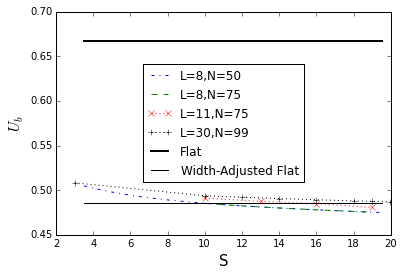

In [81]:
#plt.plot(2.*gVec,uBulkArr[0,:,0],'k-.') # Re=10
plt.plot(2.*gVec,uBulkArr[0,:,1],'b-.') # Re=1000
plt.plot(2.*gVecFine,uBulkArrFine[0,:,0],'g--') # Re=1000
plt.plot(2.*gVecFiner,uBulkArrFiner[0,:,0],'r:x') # Re=1000
plt.plot(2.*gArrTemp,uBulkArrFinest,'k:+') # Re=1000
plt.plot(2.*gVec, 2./3.*np.ones(gVec.size),'k',linewidth=2 )
plt.plot(2.*gVec, 2./3.*(0.9**3)*np.ones(gVec.size) ,'k')
plt.legend(['L=8,N=50','L=8,N=75','L=11,N=75','L=30,N=99','Flat','Width-Adjusted Flat'],loc='center')
#uBulkAsym = 2./3.*(1.-2.*tempDict['eps'])**2
plt.ylim([0.45,0.7])
plt.xlabel('S',fontsize=15); plt.ylabel('$U_b$',fontsize=15)
#plt.title('Bulk velocity for (A,Re) = (0.1,1000)' )
plt.savefig(figureFolder+'highSlopeAsym.eps',dpi=1200,format='eps')
plt.show()

In [27]:
uBulkArrFiner

array([[[ 0.49102592],
        [ 0.48752878],
        [ 0.48497031],
        [ 0.48063543],
        [ 0.4830531 ],
        [ 0.47402261],
        [ 0.48176249]]])

In [260]:
#vf = vfArrFine[0,-1,0].field.copy(); pf = pfArr[0,-1,0].field.copy() 

#vf.flowDict.update({'alpha':2000.}); pf.flowDict.update({'alpha':2000.})
vf = vf.slice(L=18,N=75); pf=pf.slice(L=18,N=75)
vf[:,:,:,:,[0,-1]] = 0.
vf,pf,fnorm,flg = iterate(vf=vf,pf=pf,iterMax=5,tol=1.0e-11)
saveff(vf,pf)

Converged in  3  iterations. Returning....................................
saved to  solutions/T00E0500Gx9500Gz0000Re1000L18M00N75


In [262]:
vf.flux(), vf.flowDict, vfFinest.flux(), vfFinest.flowDict

(array([ 0.48176249]),
 {'K': 0,
  'L': 18,
  'M': 0,
  'N': 75,
  'Re': 1000.0,
  'alpha': 190.0,
  'beta': 0.0,
  'eps': 0.050000000000000003,
  'isPois': 1,
  'lOffset': 0.0,
  'mOffset': 0.0,
  'nd': 3,
  'noise': 0.0,
  'omega': 0.0},
 array([ 0.4830531]),
 {'K': 0,
  'L': 14,
  'M': 0,
  'N': 75,
  'Re': 1000.0,
  'alpha': 190.0,
  'beta': 0.0,
  'eps': 0.050000000000000003,
  'isPois': 1,
  'lOffset': 0.0,
  'mOffset': 0.0,
  'nd': 3,
  'noise': 0.0,
  'omega': 0.0})

In [250]:
for g in [5.,6.5,8.]:
    a = g/vf.flowDict['eps']
    vf.flowDict.update({'alpha':a}); pf.flowDict.update({'alpha':a})
    vf,pf,fnorm,flg = iterate(vf=vf,pf=pf,iterMax=6,tol=1.0e-11)
    saveff(vf,pf)
    
    

Converged in  3  iterations. Returning....................................
saved to  solutions/T00E0500Gx5000Gz0000Re1000L14M00N75
Converged in  3  iterations. Returning....................................
saved to  solutions/T00E0500Gx6500Gz0000Re1000L14M00N75
Converged in  3  iterations. Returning....................................
saved to  solutions/T00E0500Gx8000Gz0000Re1000L14M00N75


In [3]:
vfCoarse = vfArr[0,-2,-1].field.copy()
vfFine = vfArrFine[0,-1,-1].field.copy()

tempDict = vfFine.flowDict.copy(); tempDict.update({'L':11,'N':75})
vf,pf = loadff(dict2name(tempDict))
vfFiner = vf.copy()

tempDict.update({'L':14})
vf,pf = loadff(dict2name(tempDict))
vfFinest = vf.copy()

tempDict.update({'L':18})
vf,pf = loadff(dict2name(tempDict))
vfFinestest = vf.copy()

tempDict.update({'L':30,'N':99})
vf,pf = loadff(dict2name(tempDict))
vfFineMax = vf.copy()


vf = vfCoarse
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
eps = vf.flowDict['eps']; a= vf.flowDict['alpha']; g = eps*a
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5coarse.eps',dpi=1200,format='eps')
plt.show()

vf = vfFine
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5fine.eps',dpi=1200,format='eps')
plt.show()

vf = vfFiner
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5finer.eps',dpi=1200,format='eps')
plt.show()


vf = vfFinest
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5finest.eps',dpi=1200,format='eps')
plt.show()


vf = vfFinestest
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),linestyle='dashed')
plt.plot(vf.y,u1.flatten(),linestyle='dotted')
plt.plot(-0.1+vf.y,u2.flatten(),linestyle='dashdot')
plt.xlabel('y'); plt.ylabel('u'); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig('G9p5finestest.eps',dpi=1200,format='eps')
plt.show()





NameError: name 'vfArr' is not defined

0.05 190.0


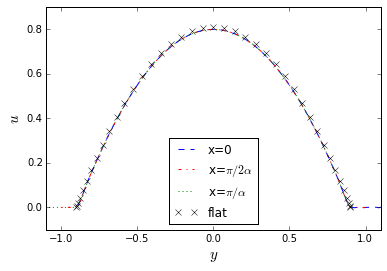

In [70]:
#vf,pf = loadff('solutions/T00E0500Gx9500Gz0000Re1000L30M00N99.npy')
vf,pf = loadff('solutions/highAlpha/L08N75/T00E0500Gx9500Gz0000Re1000L08M00N75.npy')
fName = 'G9p5fine.eps'
vfG95 = vf.copy()
eps = vf.flowDict['eps']; a = vf.flowDict['alpha']; g=eps*a
#vf = vfFineMax
plt.figure()
u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
plt.plot(0.1+vf.y,u0.flatten(),'b--')
plt.plot(vf.y,u1.flatten(),'r-.')
plt.plot(-0.1+vf.y,u2.flatten(),'g:')
plt.xlabel('$y$',fontsize=15); plt.ylabel('$u$',fontsize=15); plt.xlim([-1.1,1.1]); plt.ylim([-0.1,0.9])
yNew = 0.9*vf.slice(N=41).y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'kx')
plt.legend(['x=0','x=$\\pi/2\\alpha$','x=$\\pi/\\alpha$','flat'], loc='lower center')
print(vf.flowDict['eps'], vf.flowDict['alpha'])
#plt.title('u for (A,S) = ( %0.2f , %0.1f ) with L=%d, N=%d, $U_b$ = %0.4f' %(2.*eps,2.*g,vf.flowDict['L'], vf.flowDict['N'],vf.flux()))
plt.savefig(figureFolder+fName,dpi=1200,format='eps')
plt.show()


In [83]:
#vfG15,pfG15 = loadff('solutions/T00E0500Gx1500Gz0000Re1000L30M00N99.npy')
#vfG50,pfG50 = loadff('solutions/T00E0500Gx5000Gz0000Re1000L30M00N99.npy')
#vfG99,pfG99 = loadff('solutions/T00E0500Gx9990Gz0000Re1000L30M00N99.npy')
vfG15,pfG15 = loadff('solutions/T00E1000Gx1500Gz0000Re1000L30M00N99.npy')
vfG50,pfG50 = loadff('solutions/T00E1000Gx5000Gz0000Re1000L30M00N99.npy')
vfG99,pfG99 = loadff('solutions/T00E1000Gx9900Gz0000Re1000L30M00N99.npy')
print(vfG15.residuals(pField=pfG15).norm())
print(vfG50.residuals(pField=pfG50).norm())
print(vfG99.residuals(pField=pfG99).norm())

3.29156204301e-14
2.13614166268e-13
2.75624018745e-13


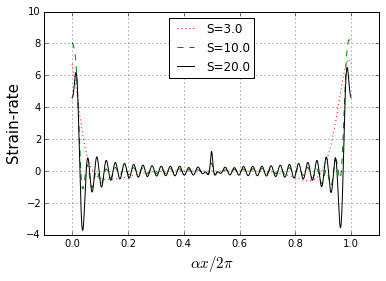

In [84]:
#fName = 'localStrainRate_highSlopeE05.eps'
fName = 'localStrainRate_highSlopeE10.eps'
plt.figure()

vf = vfG15.copy()

a = vf.flowDict['alpha']
Lx = 2.*np.pi/a
xArr = np.arange(0.,Lx*1.001,0.01*Lx)
shearDict = shearStress(vf,localDist=True)
strainRate = shearDict['strainRateFun'](xArr)

plt.plot(xArr/Lx, strainRate,'r:')


vf = vfG50.copy()

a = vf.flowDict['alpha']
Lx = 2.*np.pi/a
xArr = np.arange(0.,Lx*1.00001,0.0001*Lx)
shearDict = shearStress(vf,localDist=True)
strainRate = shearDict['strainRateFun'](xArr)

plt.plot(xArr/Lx, strainRate,'g--')

vf = vfG99.copy()

a = vf.flowDict['alpha']
Lx = 2.*np.pi/a
xArr = np.arange(0.,Lx*1.00001,0.0001*Lx)
shearDict = shearStress(vf,localDist=True)
strainRate = shearDict['strainRateFun'](xArr)

plt.plot(xArr/Lx, strainRate,'k')


plt.grid()
plt.legend(['S=3.0','S=10.0','S=20.0'],loc='upper center')
plt.xlim([-0.1,1.1])
plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format='eps')
plt.xlabel('$\\alpha x/2\\pi$',fontsize=15); plt.ylabel('Strain-rate',fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format='eps')
plt.show()


/usr/local/lib/python3.4/dist-packages/numpy-1.11.0-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


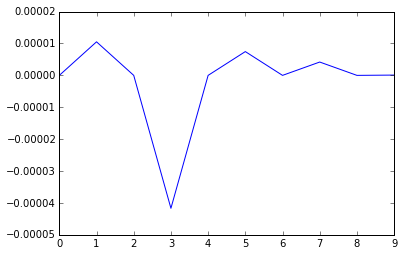

array([  1.27156205e-07,   1.28247961e-07,   1.30432846e-07,
         1.33707865e-07,   1.38056629e-07,   1.43443458e-07,
         1.49820602e-07,   1.57165542e-07,   1.65567960e-07,
         1.75381013e-07,   1.87429352e-07,   2.03213536e-07,
         2.24962408e-07,   2.55288033e-07,   2.96185715e-07,
         3.47376064e-07,   4.04683670e-07,   4.60108352e-07,
         5.05361656e-07,   5.37884164e-07,   5.61957444e-07,
         5.72375293e-07,   5.16300969e-07,   2.59460276e-07,
         3.80832688e-07,   1.48434330e-06,   2.81319411e-06,
         3.73776943e-06,   3.52176191e-06,   1.91000947e-06,
         4.53177426e-07,   2.28350514e-06,   2.62595040e-06,
         1.62292218e-06,   3.55683042e-07,   2.07472783e-07,
         6.21852623e-08])

In [293]:
for l in range(18,19):
    plt.plot(uCoeffs[l,-10:]/np.sum(np.abs(uCoeffs[l])) )
plt.show()
np.abs(uCoeffs[35,1::2])

(array([ 0.48176249]), 0.3911064085323771)

In [255]:
uArr = vfFinest.getScalar().ifft(xLoc=2.,zLoc=0.)
weights = clencurt(vf.N)
0.5*np.dot(weights,uArr.flatten()), 2./3.*(1.-2.*vf.flowDict['eps'])**3

(0.48305310328688489, 0.48600000000000004)

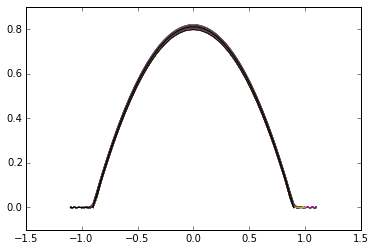

In [223]:
for k in range(5,vfArr.shape[1]):
    vf = vfArr[0,k,1].field
    u0 = vf.getScalar().ifft(xLoc=0.,zLoc=0.)
    u1 = vf.getScalar().ifft(xLoc=np.pi/2./vf.flowDict['alpha'],zLoc=0.)
    u2 = vf.getScalar().ifft(xLoc=np.pi/vf.flowDict['alpha'],zLoc=0.)
    plt.plot(0.1+vf.y,u0.flatten())
    plt.plot(vf.y,u1.flatten())
    plt.plot(-0.1+vf.y,u2.flatten())
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')

plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


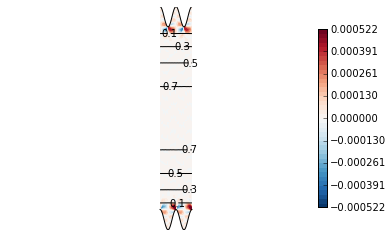

In [224]:
figHeight = 3. # Inches
vLim = [-0.06,0.06]; nvLevels = 50
vNegLevels = np.arange(-0.06,0.,0.01)
uLevels = np.arange(0.1,0.75,0.2)
cTicks = np.arange(-0.06,0.065,0.02)
nx = 40

a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
eps = vf.flowDict['eps']
X = np.tile( np.arange(0.,2*Lx+Lx/nx/2., Lx/nx).reshape((1,2*nx+1)), (vf.N,1))
Y = vf.y.reshape((vf.N,1)) + 2.*eps*np.cos(a*X)

figWidth = 2*Lx+2 # Extra inch for the colorbar
U = vf.getScalar().getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
V = vf.getScalar(nd=1).getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T

#V[V>vLim[-1]] = vLim[-1]*0.999999
#V[V<vLim[0]] = vLim[0]
#dvLim = (vLim[-1]-vLim[0])/nvLevels
#cLevels = np.arange(vLim[0],vLim[-1]+dvLim/2., dvLim)


#plt.figure(figsize=(20*figWidth,figHeight))
plt.plot(50.*X[0],Y[0],'k')
plt.plot(50.*X[-1],Y[-1],'k')

vmax = np.max(np.max(V))
vmin = -vmax

# filled contours for V
plt.contourf(50.*X,Y,V, levels=np.arange(vmin,1.001*vmax,0.05*vmax),cmap=plt.get_cmap('RdBu_r'))
plt.colorbar(shrink=0.8,pad=0.,aspect=20, ticks=np.arange(vmin,1.001*vmax,0.25*vmax))
#plt.clim(vLim)
#plt.xlim([-0.1*Lx, 2.*Lx]); plt.ylim([-1.4,1.4])
plt.axis('off'); plt.axis('equal')

# line contours for negative values of V
#plt.contour(50.*X,Y,V, colors='k',levels=vNegLevels)

# Line contours for U
uctr = plt.contour(50.*X,Y,U, colors='k', levels = uLevels)
plt.clabel(uctr,fmt='%0.1f',fontsize='x-large')

plt.margins(x=0)
plt.show()


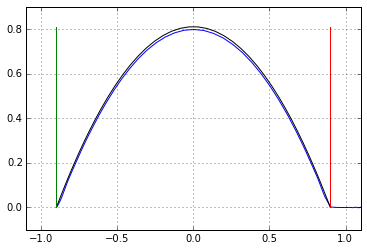

ValueError: shapes (65,) and (50,) not aligned: 65 (dim 0) != 50 (dim 0)

In [225]:
#for k in [0,5,10,15,20,25]:
for k in [0]:
    plt.plot(Y[:,k],U[:,k])
yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
plt.plot(yNew,uNew,'k')
plt.xlim([-1.1,1.1]); plt.grid(); 
plt.plot(-0.9*np.ones(yNew.size), uNew)
plt.plot(0.9*np.ones(yNew.size), uNew)
plt.show()
print(np.dot(weights,U[:,k])*0.5, 2./3.*0.9**3)

plt.figure()
for k in [0,5,10,15,20,25]:
    plt.plot(Y[:,k],V[:,k])
#yNew = 0.9*vf.y; uNew = 0.81*(1.-(yNew/0.9)**2)
#plt.plot(yNew,uNew,'k')
plt.xlim([-1.1,1.1]); plt.grid(); 
#plt.plot(-0.9*np.ones(yNew.size), uNew)
#plt.plot(0.9*np.ones(yNew.size), uNew)
plt.show()



## Analytical solution vs numerical solutions: Transverse
Plot bulk velocity, and the distance of velocity fields. 

In [7]:
Re = 100.
#epsArr = 0.5*np.arange(0.025,0.1501,0.025)
epsArr = 0.5*np.array([0.1])
aArr = 10.**(np.arange(-2.,1.001,0.2))
flowDict = getDefaultDict()
flowDict.update({'eps':epsArr[0],'beta':0.,'alpha':aArr[0], 'Re':Re,'isPois':1,'L':5,'M':0,'N':15,'nd':3})

vfList = []; pfList = []
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()
resFun = lambda vf,pf: vf.residuals(pField=pf).appendField(vf.div())
resNormFun = lambda vf, pf: resFun(vf,pf).norm()

for eps in epsArr:
    for a in aArr:
        vf.flowDict.update({'eps':eps,'alpha':a})
        pf.flowDict.update({'eps':eps,'alpha':a})
        if eps*a>0.2:
            vf = vf.slice(N=25); vf[:,:,:,:,[0,-1]]= 0.
            pf = pf.slice(N=25)
        else:
            vf = vf.slice(N=15); vf[:,:,:,:,[0,-1]]= 0.
            pf = pf.slice(N=15)
        vf, pf, flg, fnorm = iterate(vf=vf,pf=pf,iterMax=6,tol=1.0e-12)
        print(vf.flowDict['Re'], vf.flowDict['eps'], vf.flowDict['alpha'])
        print("resNorm:", resNormFun(vf,pf) )
        print("accuracy:", resNormFun( vf.slice(L=2*vf.flowDict['L'],N=2*vf.N), pf.slice(L=2*vf.flowDict['L'],N=2*vf.N)    ))
        vfList.append(vf); pfList.append(pf)
        

Converged in  2  iterations. Returning....................................
100.0 0.05 0.01


AssertionError: pField should be a scalar of the same size as each scalar of velocity

In [6]:
%debug

> /home/sabarish/Dropbox/gitwork/python3/symmetries/flowField.py(692)residuals()
    690             pField = self.getScalar(); pField[:] = 0.
    691         else:
--> 692             assert (pField.nd == 1) and (pField.size == self.size//3), 'pField should be a scalar of the same size as each scalar of velocity'
    693 
    694         vf = self.slice(nd=[0,1,2])

ipdb> pField.shape
(1, 19, 1, 1, 15)
ipdb> pField.nd
1
ipdb> self.size
1026
ipdb> self.shape
(1, 19, 1, 3, 18)
ipdb> exit


In [53]:
uBulkArr = np.zeros((epsArr.size,aArr.size)); pDragArr = uBulkArr.copy(); ReArr = uBulkArr.copy()
k = 0
for k1 in range(epsArr.size):
    for k2 in range(aArr.size):
        vf = vfList[k]; pf = pfList[k]
        uBulkArr[k1,k2] = vf.flux()
        pDragArr[k1,k2] = presDrag(pf)[0]
        ReArr[k1,k2] = vf.flowDict['Re']
        k+= 1
uBulkArr100 = uBulkArr.copy(); pDragArr100 = pDragArr.copy(); ReArr100 = ReArr.copy()

[[ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
   100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
   100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
   100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
   100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
   100.  100.  100.  100.]
 [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
   100.  100.  100.  100.]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


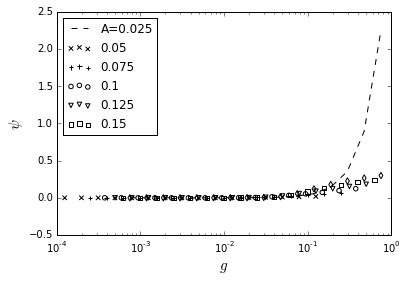

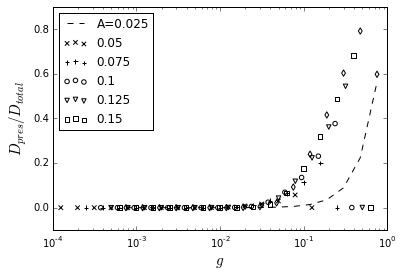

In [54]:
figureFolder = 'thesisFigures/'
markers = ['x','+','o','v','s','d']
print(ReArr100)

#fName = 'psiRe100.eps'
fName = 'psiRe100.eps'
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (1.-3./2.*uBulkArr100[k1])
    plt.scatter(gArr,  psi , marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))
plt.plot(gArr, 4.*gArr**2,'k--')
    
leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-0.05, 0.33])
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)

plt.xlabel('$g$',fontsize=15); plt.ylabel('$\\psi$',fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

#*****************************************************************
#pressure drag
fName = 'pDragRe100.eps'
#fName = 'temp.eps'
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (3./2.*uBulkArr[k1]-1.)
    plt.scatter(gArr,  pDragArr100[k1] , marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))
plt.plot(gArr, gArr**2,'k--')
    
leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('$g$',fontsize=15); plt.ylabel('$D_{pres}/D_{total}$',fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

Re: [[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
   0.1  0.1]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


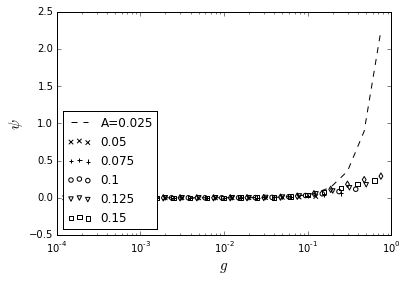

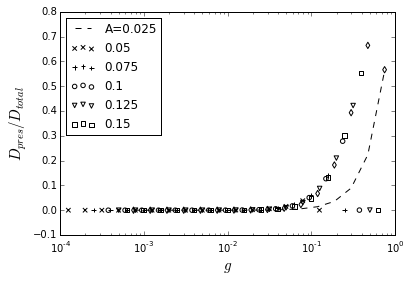

In [55]:
markers = ['x','+','o','v','s','d']
print('Re:',ReArr0p1)


fName = 'psiRe0p1.eps'
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    SArr = 2.*gArr
    psi = (1.-3./2.*uBulkArr0p1[k1])
    plt.scatter(SArr,  psi , marker=markers[k1],color='k',label='A=%.2g'%(2.*epsArr[k1]))
    leg.append(str(2.*epsArr[k1]))
plt.plot(SArr, SArr**2,'k--', label='analytical')
    
plt.legend(loc=3)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('$g$',fontsize=15); plt.ylabel('$\\psi$',fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

#*****************************************************************
#pressure drag
#fName = 'temp.eps'
fName = 'pDragRe0p1.eps'
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    plt.scatter(gArr,  pDragArr0p1[k1] , marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))
plt.plot(gArr, gArr**2,'k--')
    
leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('$g$',fontsize=15); plt.ylabel('$D_{pres}/D_{total}$',fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


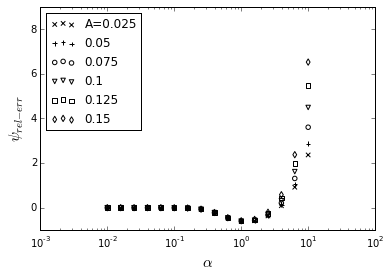

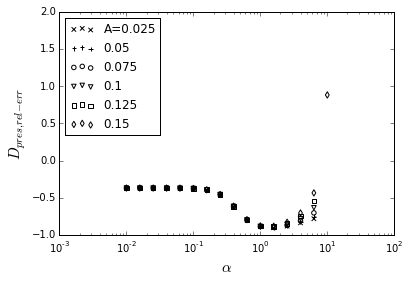

In [56]:
markers = ['x','+','o','v','s','d']

fName = 'psiRelErrRe100.eps'
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (1.-3./2.*uBulkArr100[k1])
    plt.scatter(aArr,  (4.*gArr**2 - psi)/psi, marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,9.])
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('$\\alpha$',fontsize=15); plt.ylabel('$\\psi_{rel-err}$',fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

################################
# pressure drag, relative error
fName = 'temp.eps'
#fName = 'pDragRelErrRe100.eps'
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    plt.scatter(aArr,  (2.*gArr**2 - pDragArr100[k1])/pDragArr100[k1], marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,2.])
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('$\\alpha$',fontsize=15); plt.ylabel('$D_{pres,rel-err}$',fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


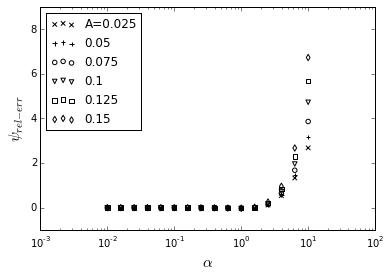

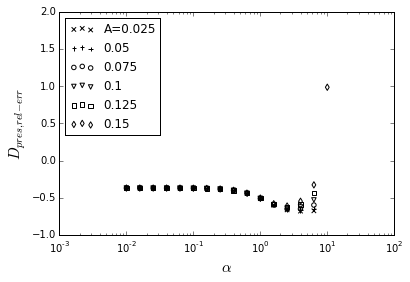

In [57]:
markers = ['x','+','o','v','s','d']

fName = 'psiRelErrRe0p1.eps'
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    psi = (1.-3./2.*uBulkArr0p1[k1])
    plt.scatter(aArr,  (4.*gArr**2 - psi)/psi, marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,9.])
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('$\\alpha$',fontsize=15); plt.ylabel('$\\psi_{rel-err}$',fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

################################
# pressure drag, relative error
#fName = 'pDragRelErrRe0p1.eps'
fName = 'temp.eps'
plt.figure()
plt.xscale("log")
leg = []

for k1 in range(6):
    gArr = epsArr[k1]*aArr
    plt.scatter(aArr,  (2.*gArr**2 - pDragArr0p1[k1])/pDragArr0p1[k1], marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,2.])
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('$\\alpha$',fontsize=15); plt.ylabel('$D_{pres,rel-err}$',fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

### Re-dependence of pressure fields in low wavenumber asymptote

In [8]:
flowDict = getDefaultDict()
L = 3; N = 10; Re = 1.; eps = 0.05; a = 0.1; g = eps*a; S=2*g
flowDict.update({'eps':eps,'alpha':a,'beta':0.,'Re':Re,'isPois':1,'L':L,'M':0,'N':N})
vf = dict2ff(flowDict); pf = vf.getScalar().zero()
vf[:] = 0.

In [9]:
Y = vf.y
Re = vf.flowDict['Re']
# u-field
vf[0,L,0,0] = (1.-S**2)*(1.-Y**2) 
vf[0,L+1,0,0] = S*a/3.*(Y**3-Y)
vf[0,L-1,0,0] = S*a/3.*(Y**3-Y)

# v-field:
vf[0,L+1,0,1] = 1.j*g*(1.-Y**2)
vf[0,L-1,0,1] = -1.j*g*(1.-Y**2)

# p-field
pf[0,L+1,0,0] = -1.j*S/Re*Y
pf[0,L+2,0,0] = -1.j*S*eps/Re
pf[0,L-1,0,0] = 1.j*S/Re*Y
pf[0,L-2,0,0] = 1.j*S*eps/Re


(-6.2831853071795862,
 125.66370614359172,
 -1.3999999999999999,
 1.3999999999999999)

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


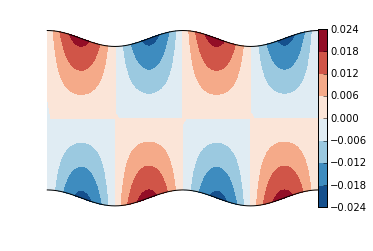

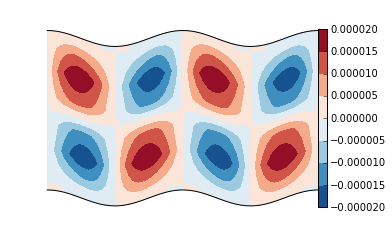

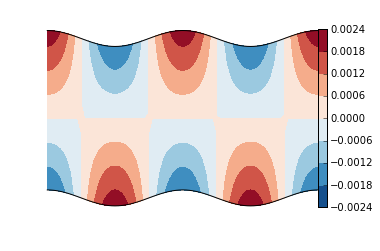

In [15]:
a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
eps = vf.flowDict['eps']
nx = 40
X = np.tile( np.arange(0.,2*Lx+Lx/nx/2., Lx/nx).reshape((1,2*nx+1)), (vf.N,1))
Y = vf.y.reshape((vf.N,1)) + 2.*eps*np.cos(a*X)

conv = vf.convNL()
pgrad = pf.grad()

figWidth = 2*Lx+2 # Extra inch for the colorbar
U = vf.getScalar().getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
V = vf.getScalar(nd=1).getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
P = pf.getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
CONV = conv.getScalar().getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
PGRAD = pgrad.getScalar().getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T

plt.figure
plt.plot(X[0],Y[0],'k')
plt.plot(X[-1],Y[-1],'k')

# filled contours for P
plt.contourf(X,Y,P, cmap=plt.get_cmap('RdBu_r'))
plt.colorbar(shrink=0.8,pad=0.,aspect=20)
plt.xlim([-0.1*Lx, 2.*Lx]); plt.ylim([-1.4,1.4])
plt.axis('off')#; plt.axis('equal')

# filled contours for conv_x
plt.figure()
plt.plot(X[0],Y[0],'k')
plt.plot(X[-1],Y[-1],'k')

plt.contourf(X,Y,CONV, cmap=plt.get_cmap('RdBu_r'))
plt.colorbar(shrink=0.8,pad=0.,aspect=20)
plt.xlim([-0.1*Lx, 2.*Lx]); plt.ylim([-1.4,1.4])
plt.axis('off')#; plt.axis('equal')


# filled contours for conv_x
plt.figure()
plt.plot(X[0],Y[0],'k')
plt.plot(X[-1],Y[-1],'k')

plt.contourf(X,Y,PGRAD, cmap=plt.get_cmap('RdBu_r'))
plt.colorbar(shrink=0.8,pad=0.,aspect=20)
plt.xlim([-0.1*Lx, 2.*Lx]); plt.ylim([-1.4,1.4])
plt.axis('off')#; plt.axis('equal')



## Local shear stress distribution 

In [102]:
flowDict = getDefaultDict()
flowDict.update({'eps':0.05,'beta':0.,'Re':10.,'isPois':1,'L':8,'M':0,'N':50})

flowDict.update({'alpha':5.})
vfLow,pfLow = loadff(dict2name(flowDict,prefix='solutions/Re10/'))

flowDict.update({'alpha':18.})
vfHigh,pfHigh = loadff(dict2name(flowDict,prefix='solutions/Re10/'))


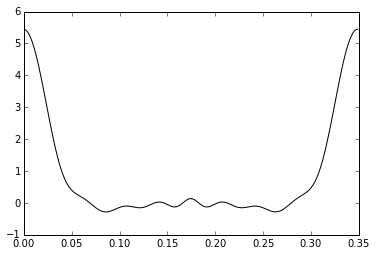

In [116]:
tempDict = shearDictHigh.copy(); a = vfHigh.flowDict['alpha']
funTest = tempDict['strainRateFun']
Lx = 2.*np.pi/a
xTest = np.arange(0.,Lx*1.001,0.005*Lx)
plt.plot(xTest, funTest(xTest),'k'); plt.show()

### Velocity contours 

In [127]:
flowDict = getDefaultDict()
flowDict.update({'eps':0.1,'beta':0.,'Re':100.,'isPois':1,'L':8,'M':0,'N':50})

flowDict.update({'alpha':1.5})
vfLow,pfLow = loadff(dict2name(flowDict,prefix='solutions/Re100/'))

flowDict.update({'alpha':4.})
vfMid,pfMid = loadff(dict2name(flowDict,prefix='solutions/Re100/'))

flowDict.update({'alpha':12.})
vfHigh,pfHigh = loadff(dict2name(flowDict,prefix='solutions/Re100/'))

In [ ]:
from matplotlib.colorbar import make_axes
vf = vfHigh; fName = 'uvContoursHigh'
figHeight = 3. # Inches
vLim = [-0.06,0.06]; nvLevels = 50
vNegLevels = np.arange(-0.06,0.,0.01)
uLevels = np.arange(0.1,0.75,0.2)
cTicks = np.arange(-0.06,0.065,0.02)
nx = 40

a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
eps = vf.flowDict['eps']
X = np.tile( np.arange(0.,2*Lx+Lx/nx/2., Lx/nx).reshape((1,2*nx+1)), (vf.N,1))
Y = vf.y.reshape((vf.N,1)) + 2.*eps*np.cos(a*X)

figWidth = 2*Lx+2 # Extra inch for the colorbar
U = vf.getScalar().getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
V = vf.getScalar(nd=1).getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T

V[V>vLim[-1]] = vLim[-1]*0.999999
V[V<vLim[0]] = vLim[0]
dvLim = (vLim[-1]-vLim[0])/nvLevels
cLevels = np.arange(vLim[0],vLim[-1]+dvLim/2., dvLim)


plt.figure(figsize=(figWidth,figHeight))
plt.plot(X[0],Y[0],'k')
plt.plot(X[-1],Y[-1],'k')

# filled contours for V
plt.contourf(X,Y,V,levels = cLevels, cmap=plt.get_cmap('RdBu_r'))
plt.colorbar(shrink=0.8,pad=0.,aspect=20, ticks=cTicks)
plt.clim(vLim)
plt.xlim([-0.1*Lx, 2.*Lx]); plt.ylim([-1.4,1.4])
plt.axis('off'); plt.axis('equal')

# line contours for negative values of V
plt.contour(X,Y,V, colors='k',levels=vNegLevels)

# Line contours for U
uctr = plt.contour(X,Y,U, colors='k', levels = uLevels)
plt.clabel(uctr,fmt='%0.1f',fontsize='x-large')

plt.margins(x=0)
plt.savefig(fName+'.eps',dpi=600,format='eps')
plt.savefig(fName+'.tiff',dpi=600,format='tiff')
plt.show()


## Shear strain rate distribution 

In [128]:
shearDictLow = shearStress(vfLow,localDist=True)
shearDictMid = shearStress(vfMid,localDist=True)
shearDictHigh = shearStress(vfHigh,localDist=True)


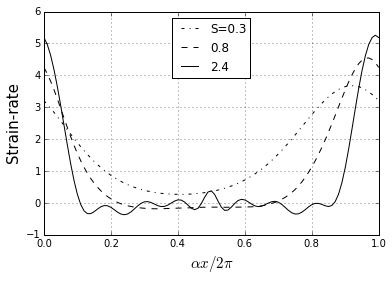

In [129]:
aLow = 1.5; aMid=4.; aHigh=12.
LxLow = 2.*np.pi/aLow; LxMid = 2.*np.pi/aMid; LxHigh = 2.*np.pi/aHigh
xArrLow = np.arange(0.,LxLow*1.001,0.01*LxLow)
xArrMid = np.arange(0.,LxMid*1.001,0.01*LxMid)
xArrHigh = np.arange(0.,LxHigh*1.001,0.01*LxHigh)

strainRateLow = shearDictLow['strainRateFun'](xArrLow)
strainRateMid = shearDictMid['strainRateFun'](xArrMid)
strainRateHigh = shearDictHigh['strainRateFun'](xArrHigh)

plt.figure()
plt.plot(np.arange(0.,1.001,0.01), strainRateLow,'k-.')
plt.plot(np.arange(0.,1.001,0.01), strainRateMid,'k--')
plt.plot(np.arange(0.,1.001,0.01), strainRateHigh,'k')
plt.grid()
plt.legend(['S=0.3','0.8','2.4'],loc='upper center')
plt.savefig(figureFolder+'noLabels/'+'localStrainRate.eps',dpi=600,format='eps')
plt.xlabel('$\\alpha x/2\\pi$',fontsize=15); plt.ylabel('Strain-rate',fontsize=15)
plt.savefig(figureFolder+'localStrainRate.eps',dpi=1200,format='eps')
plt.show()


## Re-dependence

In [ ]:
import sys
epsArr = 0.5*np.array([0.05,0.15])
gArr = 0.5*np.array([0.5])
ReArr = (10.**(np.arange(0.,3.1,0.5)))
savePath = 'solutions/ReDep/'

flowDict = getDefaultDict()
flowDict.update({'eps':epsArr[0.025],'beta':0.,'Re':10.,'isPois':1,'L':8,'M':0,'N':50,'nd':3})
vf = dict2ff(flowDict); pf = vf.getScalar().zero()

for eps in epsArr:
    vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
    for g in gArr:
        a = g/eps
        vf.flowDict.update({'alpha':a}); pf.flowDict.update({'alpha':a})
        for Re in ReArr:
            Re = round(Re,0)
            print('(eps,g,Re):',(eps,g,Re))
            vf.flowDict.update({'Re':Re}); pf.flowDict.update({'Re':Re})
            vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=8, tol= 1.0e-12)
            saveff(vf,pf,prefix=savePath)
            sys.stdout.flush()

In [4]:
loadPath = 'solutions/ReDep/'
files = os.listdir(loadPath)
files.sort()
vfList = []; pfList = []
for fName in files:
    vf,pf = loadff(loadPath+fName)
    vfList.append(vf); pfList.append(pf)

vfArr = flowFieldArray(vfList,2,len(vfList)//14,7); pfArr = flowFieldArray(pfList, 2,len(pfList)//14,7)
UbArr = vfArr.getProperty('flux')
epsArr = vfArr.getProperty('eps')
ReArr = vfArr.getProperty('Re')
gArr = vfArr.getProperty('g')
aArr = gArr/epsArr

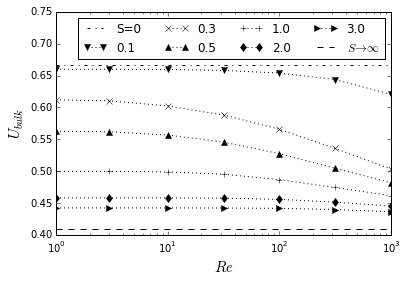

In [13]:
eInd = 1; fName= 'UbReDepE075.eps'
markers=['v','x','^','+','d','>']
upBound = 2./3.
lowBound = 2./3.*(1.-2.*epsArr[eInd,0,0])**3
plt.figure()
leg = []
plt.plot(ReArr[eInd,0,:], upBound*np.ones(ReArr.shape[2]),'k-.'); leg.append("S=0")
for k in range(6):
    plt.plot(ReArr[eInd,k], UbArr[eInd,k],'k:',marker=markers[k]); leg.append(2.*gArr[eInd,k,0])
plt.plot(ReArr[eInd,k], lowBound*np.ones(ReArr.shape[2]),'k--'); leg.append("$S \\to \\infty$")

#plt.legend([2.*gArr[eInd,:5,0],"flat","$g \to \infty$"],loc='upper right',ncol=2)

plt.legend(leg,loc='upper right',ncol=4)
plt.xscale("log")
plt.ylim([0.4,0.75])

plt.savefig(figureFolder+'noLabels/'+fName, dpi=1200,format='eps')
plt.ylabel("$U_{bulk}$",fontsize=15); plt.xlabel("$Re$",fontsize=15)
plt.savefig(figureFolder+fName, dpi=1200,format='eps')
plt.show()

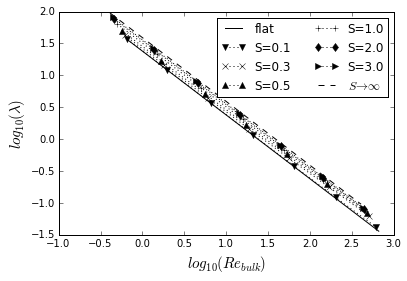

In [9]:
eInd = 1; fName= 'fricFacReDepLogE075.eps'
markers=['v','x','^','+','d','>']
upBound = 2./3.
lowBound = 2./3.*(1.-2.*epsArr[eInd,0,0])**3
plt.figure()
leg = []
plt.plot(np.log10(upBound*ReArr[0,0]),np.log10(16./upBound**2/ReArr[0,0]), 'k'); leg.append('flat')
for k in range(6):
    plt.plot(np.log10(UbArr[eInd,k]*ReArr[eInd,k]), np.log10(16./UbArr[eInd,k]**2/ReArr[eInd,k]),'k:',marker=markers[k]); leg.append('S='+str(2.*gArr[eInd,k,0]))
plt.plot(np.log10(lowBound*ReArr[0,0]),np.log10(16./lowBound**2/ReArr[0,0]), 'k--'); leg.append('$S \\to \\infty$')
    
plt.legend(leg,loc='upper right',ncol=2)
#plt.xscale("log")
#plt.xlim([0.1,10000])
plt.xlim([-1.,3.])
#plt.ylim([0.4,0.75])

plt.savefig(figureFolder+'noLabels/'+fName, dpi=1200,format='eps')
plt.ylabel("$log_{10}(\\lambda)$",fontsize=15); plt.xlabel("$log_{10}(Re_{bulk})$",fontsize=15)
plt.savefig(figureFolder+fName, dpi=1200,format='eps')
plt.show()

# Oblique Solutions

## Running for oblique solutions

In [ ]:
theta = np.pi/3; tanTheta = np.sqrt(3)
savePath = 'solutions/T60/Re100/'

flowDict = getDefaultDict()
flowDict.update({'eps':0.01,'beta':1.,'Re':10.,'isPois':1,'L':8,'M':8,'N':50})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()

epsArr = -0.005+np.arange(0.01,0.1001,0.01)
gxArr = np.arange(0.1,1.501,0.1)
ReArr = np.array([100.])
for k1 in range(epsArr.size):
    eps = round(epsArr[k1],4)
    vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
    for k2 in range(gxArr.size):
        gx = round(gxArr[k2],3)
        a = gx/eps
        b = a*tanTheta
        vf.flowDict.update({'alpha':a,'beta':b}); pf.flowDict.update({'alpha':a,'beta':b})
        for k3 in range(ReArr.size):
            Re = ReArr[k3]
            print('eps, gx, Re:',eps,gx,Re)
            vf.flowDict.update({'Re':Re}); pf.flowDict.update({'Re':Re})
            start1 = time.time()
            vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=8,tol=1.0e-11)
            saveff(vf,pf,prefix=savePath)
            print("Runtime:",np.int(time.time()-start1))
            sys.stdout.flush()
        


## Loading solutions (T=0, pi/6, pi/3)

In [51]:
# Loading T=0 solutions into vfArrT0
loadPath = 'solutions/Re100/'
neps = 20
vfList = []; pfList = []
files = os.listdir(loadPath)
files.sort()
for f in files:
    vf, pf = loadff(loadPath+f)
    vfList.append(vf.copy())
    pfList.append(pf.copy())
vfArr = flowFieldArray(vfList, neps,len(vfList)//neps,1)
pfArr = flowFieldArray(pfList, neps,len(vfList)//neps,1)

uBulkArrT0 = vfArr.getProperty('flux').reshape((neps,vfArr.size//neps))
epsArrT0 = vfArr.getProperty('eps').reshape((neps,vfArr.size//neps))
gxArrT0 = vfArr.getProperty('eps')*vfArr.getProperty('a')
gxArrT0 = gxArrT0.reshape((neps,vfArr.size//neps))

vCoreT0 = uBulkArrT0.copy()
pDragT0 = uBulkArrT0.copy()
yBubArrT0 = uBulkArrT0.copy()
for k1 in range(vCoreT0.shape[0]):
    for k2 in range(vCoreT0.shape[1]):
        vf = vfArr[k1,k2,0].field
        pf = pfArr[k1,k2,0].field
        
        vCoreT0[k1,k2] = vCL_RMS(vf)
        
        stressDict = shearStress(vf, seprn=True)
        yBubArrT0[k1,k2] = stressDict['yBub']
        
        pDx,pDz = presDrag(pf)
        pDragT0[k1,k2] = pDx

yBubArrT0[np.isnan(yBubArrT0)] = -0.00001        

In [6]:
# Loading T=30 solutions into vfArrT30
loadPath = 'solutions/T30/Re100/'
neps = 20
vfList = []; pfList = []
files = os.listdir(loadPath)
files.sort()
for f in files:
    vf, pf = loadff(loadPath+f)
    vfList.append(vf.copy())
    pfList.append(pf.copy())
vfArr = flowFieldArray(vfList, neps,len(vfList)//neps,1)
pfArr = flowFieldArray(pfList, neps,len(vfList)//neps,1)

uBulkArrT30 = vfArr.getProperty('flux').reshape((neps,vfArr.size//neps))
wBulkArrT30 = vfArr.getProperty('flux',nd=2).reshape((neps, vfArr.size//neps))
epsArrT30 = vfArr.getProperty('eps').reshape((neps,vfArr.size//neps))
gxArrT30 = vfArr.getProperty('eps')*vfArr.getProperty('a')
gxArrT30 = gxArrT30.reshape((neps,vfArr.size//neps))

yBubArrT30 = uBulkArrT30.copy()
vCoreT30 = uBulkArrT30.copy()
pDragT30 = uBulkArrT30.copy()
pDragZT30 = pDragT30.copy()
for k1 in range(vCoreT30.shape[0]):
    for k2 in range(vCoreT30.shape[1]):
        vf = vfArr[k1,k2,0].field
        pf = pfArr[k1,k2,0].field
        
        vCoreT30[k1,k2] = vCL_RMS(vf)
        
        stressDict = shearStress(vf, seprn=True)
        yBubArrT30[k1,k2] = stressDict['yBub']
        
        pDx,pDz = presDrag(pf)
        pDragT30[k1,k2] = pDx
        pDragZT30[k1,k2] = pDz
yBubArrT30[np.isnan(yBubArrT30)] = -0.00001        

/home/sabarish/Dropbox/gitwork/python3/flowFieldV2/laminar.py:200: UserWarning: The average shear stress is likely to be inaccurate, since I do not account for du_tau/dn
  warn('The average shear stress is likely to be inaccurate, since I do not account for du_tau/dn')


In [7]:
# Loading T=60 solutions into vfArrT60
loadPath = 'solutions/T60/Re100/'
neps = 20
vfList = []; pfList = []
files = os.listdir(loadPath)
files.sort()
for f in files:
    vf, pf = loadff(loadPath+f)
    vfList.append(vf.copy())
    pfList.append(pf.copy())
vfArr = flowFieldArray(vfList, neps,len(vfList)//neps,1)
pfArr = flowFieldArray(pfList, neps,len(vfList)//neps,1)

uBulkArrT60 = vfArr.getProperty('flux').reshape((neps,vfArr.size//neps))
wBulkArrT60 = vfArr.getProperty('flux',nd=2).reshape((neps, vfArr.size//neps))
epsArrT60 = vfArr.getProperty('eps').reshape((neps,vfArr.size//neps))
gxArrT60 = vfArr.getProperty('eps')*vfArr.getProperty('a')
gxArrT60 = gxArrT60.reshape((neps,vfArr.size//neps))

yBubArrT60 = uBulkArrT60.copy()
vCoreT60 = uBulkArrT60.copy()
pDragT60 = uBulkArrT60.copy()
pDragZT60 = pDragT60.copy()
for k1 in range(vCoreT60.shape[0]):
    for k2 in range(vCoreT60.shape[1]):
        vf = vfArr[k1,k2,0].field
        pf = pfArr[k1,k2,0].field
        
        vCoreT60[k1,k2] = vCL_RMS(vf)
        
        stressDict = shearStress(vf, seprn=True)
        yBubArrT60[k1,k2] = stressDict['yBub']
        
        pDx,pDz = presDrag(pf)
        pDragT60[k1,k2] = pDx
        pDragZT60[k1,k2] = pDz
yBubArrT60[np.isnan(yBubArrT60)] = -0.00001        

/home/sabarish/Dropbox/gitwork/python3/flowFieldV2/laminar.py:200: UserWarning: The average shear stress is likely to be inaccurate, since I do not account for du_tau/dn
  warn('The average shear stress is likely to be inaccurate, since I do not account for du_tau/dn')


/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


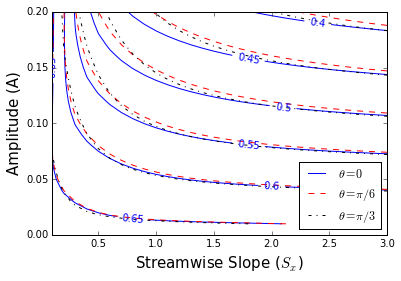

In [72]:
fName = 'uBulkOblique.eps'
UbulkLevels = np.arange(0.4,0.66,0.05)
CtrT0=None; CtrT30=None; CtrT60=None
plt.figure()
CtrT0 = plt.contour(2.*gxArrT0, 2.*epsArrT0, uBulkArrT0,levels=UbulkLevels,colors='b')
plt.clabel(CtrT0,fmt='%0.2g',fontsize='x-large')
CtrT30 = plt.contour(2.*gxArrT30, 2.*epsArrT30, uBulkArrT30,levels=UbulkLevels,colors ='r',linestyles='dashed')
#plt.clabel(CtrT30,fmt='%0.2g',fontsize='x-large')
CtrT60 = plt.contour(2.*gxArrT60, 2.*epsArrT60, uBulkArrT60,levels=UbulkLevels,colors='k',linestyles='dashdot')
#plt.clabel(CtrT60,fmt='%0.2g',fontsize='x-large')

plt.ylim([0.,0.2])
plt.legend([CtrT0.collections[0],CtrT30.collections[0]],["$\\theta=0$", "$\\theta=\\pi/6$"],loc='lower right')
plt.legend([CtrT0.collections[0],CtrT30.collections[0],CtrT60.collections[0]],["$\\theta=0$", "$\\theta=\\pi/6$", "$\\theta=\\pi/3$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format="eps")
plt.xlabel("Streamwise Slope ($S_x$)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format="eps")
plt.show()


/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


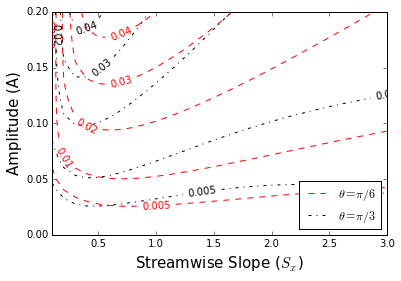

In [71]:
fName = 'wBulkOblique.eps'
#WbulkLevels = np.arange(0.01,0.06,0.01)
WbulkLevels = np.array([0.005,0.01,0.02,0.03,0.04])
CtrT30=None; CtrT60=None
plt.figure()
#CtrT0 = plt.contour(2.*gxArrT0, 2.*epsArrT0, uBulkArrT0,levels=UbulkLevels,colors='k')
#plt.clabel(CtrT0,fmt='%0.2g',fontsize='x-large')
CtrT30 = plt.contour(2.*gxArrT30, 2.*epsArrT30, -wBulkArrT30,levels=WbulkLevels,colors ='r',linestyles='dashed')
plt.clabel(CtrT30,fmt='%0.2g',fontsize='x-large')
CtrT60 = plt.contour(2.*gxArrT60, 2.*epsArrT60, -wBulkArrT60,levels=WbulkLevels,colors='k',linestyles='dashdot')
plt.clabel(CtrT60,fmt='%0.2g',fontsize='x-large')

plt.ylim([0.,0.2])
plt.legend([CtrT30.collections[0],CtrT60.collections[0]],["$\\theta=\\pi/6$", "$\\theta=\\pi/3$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format="eps")
plt.xlabel("Streamwise Slope ($S_x$)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format="eps")
plt.show()


## vCore

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


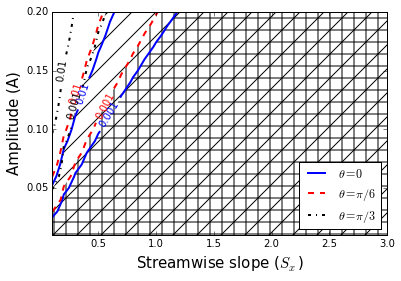

In [70]:
fName = 'vCoreOblique.eps'
plt.figure()

# vCore
vCoreLevels= [0.001,0.01]
gArr = gxArrT30; epsArr = epsArrT30
CT0 = plt.contour(2.*gArr, 2.*epsArr, vCoreT0,levels=vCoreLevels,colors='b',linewidths=2)
CT0hatch = plt.contourf(2.*gArr, 2.*epsArr, vCoreT0,levels=[0.,0.001],hatches=['-'],colors='none')
plt.clabel(CT0,fmt='%0.4g',fontsize='x-large')
CT30 = plt.contour(2.*gArr, 2.*epsArr, vCoreT30, levels=vCoreLevels, colors='r',linestyles='dashed',linewidths=2)
CT30hatch = plt.contourf(2.*gArr, 2.*epsArr, vCoreT30,levels=[0.,0.001],hatches=['|'],colors='none')
plt.clabel(CT30,fmt='%0.4g',fontsize='x-large')
CT60 = plt.contour(2.*gArr, 2.*epsArr, vCoreT60, levels=vCoreLevels, colors='k',linestyles='dashdot',linewidths=2)
CT60hatch = plt.contourf(2.*gArr, 2.*epsArr, vCoreT60,levels=[0.,0.001],hatches=['/'],colors='none')
plt.clabel(CT60,fmt='%0.4g',fontsize='x-large')
plt.legend([CT0.collections[0],CT30.collections[0],CT60.collections[0]],["$\\theta=0$", "$\\theta=\\pi/6$", "$\\theta=\\pi/3$"],loc='lower right')


plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format="eps")
plt.xlabel("Streamwise slope ($S_x$)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format="eps")
plt.show()

## Pressure drag

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


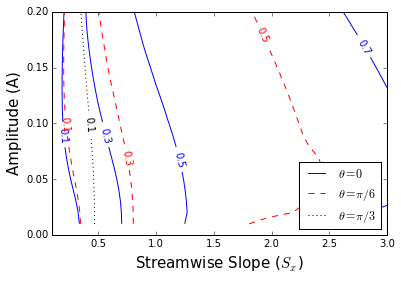

In [65]:
fName = 'pDragOblique.eps'
pDragLevels = np.arange(0.1,0.95,0.2)
YbubLevels = np.arange(0.,0.95,0.2)
CtrT0=None; CtrT30=None; CtrT60=None
plt.figure()
CtrT0 = plt.contour(2.*gxArrT0, 2.*epsArrT0, pDragT0,levels=pDragLevels,colors='b')
plt.clabel(CtrT0,fmt='%0.2g',fontsize='x-large')
CtrT30 = plt.contour(2.*gxArrT30, 2.*epsArrT30, pDragT30,levels=pDragLevels,colors ='r',linestyles='dashed')
plt.clabel(CtrT30,fmt='%0.2g',fontsize='x-large')
CtrT60 = plt.contour(2.*gxArrT60, 2.*epsArrT60, pDragT60,levels=pDragLevels,colors='k',linestyles='dotted')
plt.clabel(CtrT60,fmt='%0.2g',fontsize='x-large')

plt.ylim([0.,0.2])
plt.legend([CtrT0.collections[0],CtrT30.collections[0]],["$\\theta=0$", "$\\theta=\\pi/6$"],loc='lower right')
plt.legend([CtrT0.collections[0],CtrT30.collections[0],CtrT60.collections[0]],["$\\theta=0$", "$\\theta=\\pi/6$", "$\\theta=\\pi/3$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format="eps")
plt.xlabel("Streamwise Slope ($S_x$)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format="eps")
plt.show()


/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


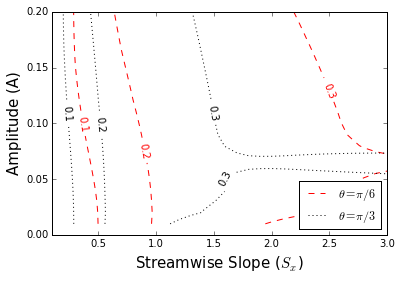

In [64]:
fName = 'pDragZOblique.eps'
pDragLevels = np.arange(0.1,0.3001,0.1)
CtrT30=None; CtrT60=None
plt.figure()
CtrT30 = plt.contour(2.*gxArrT30, 2.*epsArrT30, pDragZT30,levels=pDragLevels,colors ='r',linestyles='dashed')
plt.clabel(CtrT30,fmt='%0.2g',fontsize='x-large')
CtrT60 = plt.contour(2.*gxArrT60, 2.*epsArrT60, pDragZT60,levels=pDragLevels,colors='k',linestyles='dotted')
plt.clabel(CtrT60,fmt='%0.2g',fontsize='x-large')

plt.ylim([0.,0.2])
plt.legend([CtrT30.collections[0],CtrT60.collections[0]],["$\\theta=\\pi/6$", "$\\theta=\\pi/3$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format="eps")
plt.xlabel("Streamwise Slope ($S_x$)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format="eps")
plt.show()


## Separation bubble height

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


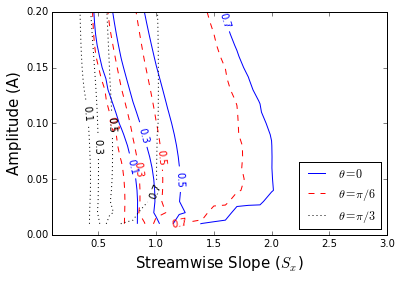

In [63]:
fName = 'YbubOblique.eps'
YbubLevels = np.arange(0.1,0.85,0.2)
CtrT0=None; CtrT30=None; CtrT60=None
plt.figure()
CtrT0 = plt.contour(2.*gxArrT0, 2.*epsArrT0, yBubArrT0,levels=YbubLevels,colors='b')
plt.clabel(CtrT0,fmt='%0.2g',fontsize='x-large')
CtrT30 = plt.contour(2.*gxArrT30, 2.*epsArrT30, yBubArrT30,levels=YbubLevels,colors ='r',linestyles='dashed')
plt.clabel(CtrT30,fmt='%0.2g',fontsize='x-large')
CtrT60 = plt.contour(2.*gxArrT60, 2.*epsArrT60, yBubArrT60,levels=YbubLevels,colors='k',linestyles='dotted')
plt.clabel(CtrT60,fmt='%0.2g',fontsize='x-large')

plt.ylim([0.,0.2])
plt.legend([CtrT0.collections[0],CtrT30.collections[0]],["$\\theta=0$", "$\\theta=\\pi/6$"],loc='lower right')
plt.legend([CtrT0.collections[0],CtrT30.collections[0],CtrT60.collections[0]],["$\\theta=0$", "$\\theta=\\pi/6$", "$\\theta=\\pi/3$"],loc='lower right')
plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format="eps")
plt.xlabel("Streamwise Slope ($S_x$)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format="eps")
plt.show()


## Oblique: Velocity contours

In [97]:
def getField(scalar,nxi= 20):
    """Return physical field for scalar at 20 points per wavelength in xi
    Shape of returned array is (nXi,scalar.N)"""
    scalar = scalar.getScalar()
    a = scalar.flowDict['alpha']; b = scalar.flowDict['beta']
    gma = np.sqrt(a**2+b**2); Lxi = 2.*np.pi/gma
    xiArr = np.arange(0., 2.001*Lxi, Lxi/nxi)
    
    scalarField = np.zeros((xiArr.size, scalar.N))
    for kxi in range(xiArr.size):
        xi = xiArr[kxi]
        scalarField[kxi] = scalar.ifft(xLoc=a/gma*xi, zLoc = b/gma*xi)
    
    return scalarField


saved to uwContoursObliqueT60E0500Gx1300.eps


/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


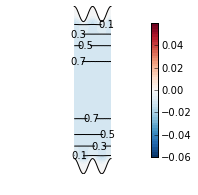

In [159]:
#vf = .........
fNamePrefix = 'uwContoursOblique'
a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
eps = vf.flowDict['eps']

fName = fNamePrefix+'T%02dE%04dGx%04d'%(60,10000.*eps, 1000.*eps*a)
figHeight = 3. # Inches
vLim = [-0.06,0.06]; nvLevels = 50
vNegLevels = np.arange(-0.06,0.,0.01)

wLim = [-0.06,0.06]; nwLevels = 50
wNegLevels = np.arange(-0.06,0.,0.02)
cTicks = np.arange(-0.06,0.06,0.02)

uLevels = np.arange(0.1,0.75,0.2)
nx = 40

a = vf.flowDict['alpha']; Lx = 2.*np.pi/a
eps = vf.flowDict['eps']
X = np.tile( np.arange(0.,2*Lx+Lx/nx/2., Lx/nx).reshape((1,2*nx+1)), (vf.N,1))
Y = vf.y.reshape((vf.N,1)) + 2.*eps*np.cos(a*X)

figWidth = 2*Lx+2 # Extra inch for the colorbar
U = vf.getScalar().getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
V = vf.getScalar(nd=1).getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
W = vf.getScalar(nd=2).getPhysical(xLoc=X[0]).reshape((X.shape[1],vf.N)).T
#W = -W

"""V[V>vLim[-1]] = vLim[-1]*0.999999
V[V<vLim[0]] = vLim[0]
dvLim = (vLim[-1]-vLim[0])/nvLevels
cLevels = np.arange(vLim[0],vLim[-1]+dvLim/2., dvLim)"""

W[W>wLim[-1]] = wLim[-1]*0.999999
W[W<wLim[0]] = wLim[0]
dwLim = (wLim[-1]-wLim[0])/nwLevels
wcLevels = np.arange(wLim[0],wLim[-1]+dwLim/2., dwLim)


plt.figure(figsize=(figWidth,figHeight))
plt.plot(X[0],Y[0],'k')
plt.plot(X[-1],Y[-1],'k')

# filled contours for W
plt.contourf(X,Y,W,levels = wcLevels, cmap=plt.get_cmap('RdBu_r'))
plt.colorbar(shrink=0.8,pad=0.0,aspect=20, ticks=cTicks)
plt.clim(wLim)
plt.xlim([-0.1*Lx, 2.*Lx]); plt.ylim([-1.4,1.4])
plt.axis('off'); plt.axis('equal')

# line contours for negative values of V
#plt.contour(X,Y,W, colors='k',levels=wNegLevels)

# Line contours for U
uctr = plt.contour(X,Y,U, colors='k', levels = uLevels)
plt.clabel(uctr,fmt='%0.1f',fontsize='x-large')

plt.margins(x=0)
plt.savefig(fName+'.eps',dpi=600,format='eps')
print("saved to",fName+'.eps')
#plt.savefig(fName+'.tiff',dpi=600,format='tiff')
plt.show()


## Oblique: Local shear strain-rate distribution, streamwise and spanwise

## Oblique - theta Dependence

In [ ]:
savePath = 'solutions/thetaDepNew/'
epsArr = np.array([0.05])
gxArr = np.array([0.1,0.4,1.0])
thetaArr = np.pi/180.*np.arange(5.,76.,10.)
tanThetaArr = np.tan(thetaArr)

Re=100.
flowDict = getDefaultDict()
flowDict.update({'eps':epsArr[0],'beta':10.,'alpha':40.,'Re':Re,'isPois':1,'L':8,'M':8,'N':50})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()

for k0 in range(thetaArr.size):
    tanTheta = tanThetaArr[k0]
    theta = thetaArr[k0]
    for k1 in range(epsArr.size):
        eps = round(epsArr[k1],4)
        vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
        for k2 in range(gxArr.size):
            gx = round(gxArr[k2],3)
            a = gx/eps
            b = tanTheta*a
            vf.flowDict.update({'alpha':a,'beta':b}); pf.flowDict.update({'alpha':a, 'beta':b})
            print('theta,eps, gx:',theta, eps,gx)
            start1 = time.time()
            vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=6,tol=1.0e-11)
            saveff(vf,pf,prefix=savePath)
            print("Runtime:",np.int(time.time()-start1))
            sys.stdout.flush()


            

In [ ]:
savePath = 'solutions/thetaDepNew/'
theta = 0.; tanTheta = 0.

epsArr = np.array([0.05])
gxArr = np.array([0.1,0.4,1.0])
Re=100.
flowDict = getDefaultDict()
flowDict.update({'eps':epsArr[0],'beta':0.,'alpha':40.,'Re':Re,'isPois':1,'L':8,'M':0,'N':50})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()

for k1 in range(epsArr.size):
    eps = round(epsArr[k1],4)
    vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
    for k2 in range(gxArr.size):
        gx = round(gxArr[k2],3)
        a = gx/eps
        b = 0.
        vf.flowDict.update({'alpha':a,'beta':b}); pf.flowDict.update({'alpha':a, 'beta':b})
        print('theta,eps, gx:',theta, eps,gx)
        start1 = time.time()
        vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=6,tol=1.0e-11)
        saveff(vf,pf,prefix=savePath)
        print("Runtime:",np.int(time.time()-start1))
        sys.stdout.flush()


In [4]:
# Constant gamma for different alignment angles
# b = a.tanTheta
# a**2 + b**2 = gma**2 = const.
# a**2 (1 + tanTheta**2) = gma**2
# a = gma/sqrt{(1+tanTheta**2)}
# gx = g/sqrt{(1+tanTheta**2)}

savePath = 'solutions/thetaDepGamma/'
#thetaArr = np.pi/180.*np.arange(5.,86.,5.)
thetaArr = np.pi/180.*np.array([90.])
tanThetaArr = np.tan(thetaArr)
gArr = np.array([0.1,0.4,1.0])
epsArr = np.array([0.05])

nTheta = thetaArr.size; ng = gArr.size; neps = epsArr.size  # Number of cases for each parameter in ./solutions/thetaDep

Re=100.
flowDict = getDefaultDict()
flowDict.update({'eps':epsArr[0],'beta':10.,'alpha':40.,'Re':Re,'isPois':1,'L':8,'M':8,'N':50})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()

for k0 in range(thetaArr.size):
    tanTheta = tanThetaArr[k0]
    theta = thetaArr[k0]
    for k1 in range(epsArr.size):
        eps = round(epsArr[k1],4)
        vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
        for k2 in range(gArr.size):
            g = gArr[k2]
            gx = g/np.sqrt(1. + tanTheta**2)
            gx = round(gx,3)
            gz = round(gx*tanTheta,3)
            a = gx/eps
            b = gz/eps
            if a == 0.: a = 0.001
            thetaNew = np.arctan(b/a)
            vf.flowDict.update({'alpha':a,'beta':b}); pf.flowDict.update({'alpha':a, 'beta':b})
            print('thetaNew,eps, gx, gz, gNew:',thetaNew, eps,gx, gz, np.sqrt(gx**2 + gz**2))
            start1 = time.time()
            vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=6,tol=1.0e-11)
            saveff(vf,pf,prefix=savePath)
            print("Runtime:",np.int(time.time()-start1))
            sys.stdout.flush()



thetaNew,eps, gx, gz, gNew: 0.08975817419 0.05 0.1 0.009 0.10040418318
Converged in  4  iterations. Returning....................................
saved to  solutions/thetaDepGamma/T05E0500Gx0100Gz0009Re0100L08M08N50
Runtime: 189
thetaNew,eps, gx, gz, gNew: 0.0877140538911 0.05 0.398 0.035 0.399535980858
Converged in  4  iterations. Returning....................................
saved to  solutions/thetaDepGamma/T05E0500Gx0398Gz0035Re0100L08M08N50
Runtime: 188
thetaNew,eps, gx, gz, gNew: 0.0871282528751 0.05 0.996 0.087 0.999792478467
Converged in  4  iterations. Returning....................................
saved to  solutions/thetaDepGamma/T04E0500Gx0996Gz0087Re0100L08M08N50
Runtime: 187
thetaNew,eps, gx, gz, gNew: 1.48363905224 0.05 0.009 0.103 0.103392456205
Converged in  4  iterations. Returning....................................
saved to  solutions/thetaDepGamma/T85E0500Gx0009Gz0103Re0100L08M08N50
Runtime: 187
thetaNew,eps, gx, gz, gNew: 1.48351861385 0.05 0.035 0.4 0.401528330258

In [6]:
savePath = 'solutions/thetaDepGamma/'
#thetaArr = np.pi/180.*np.arange(5.,86.,5.)
gArr = np.array([0.1,0.4,1.0])
epsArr = np.array([0.05])

nTheta = 1; ng = gArr.size; neps = epsArr.size  # Number of cases for each parameter in ./solutions/thetaDep

Re=100.
flowDict = getDefaultDict()
flowDict.update({'eps':epsArr[0],'beta':20.,'alpha':0.,'Re':Re,'isPois':1,'L':0,'M':8,'N':50})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()

for k1 in range(epsArr.size):
    eps = round(epsArr[k1],4)
    vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
    for k2 in range(gArr.size):
        g = gArr[k2]
        gx = 0.
        gz = round(g,3)
        a = gx/eps
        b = gz/eps
        vf.flowDict.update({'alpha':a,'beta':b}); pf.flowDict.update({'alpha':a, 'beta':b})
        print('eps, gx, gz, gNew:', eps,gx, gz, np.sqrt(gx**2 + gz**2))
        start1 = time.time()
        vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=6,tol=1.0e-11)
        saveff(vf,pf,prefix=savePath)
        print("Runtime:",np.int(time.time()-start1))
        sys.stdout.flush()



eps, gx, gz, gNew: 0.05 0.0 0.1 0.1
Converged in  1  iterations. Returning....................................
saved to  solutions/thetaDepGamma/T90E0500Gx0000Gz0100Re0100L00M08N50
Runtime: 55
eps, gx, gz, gNew: 0.05 0.0 0.4 0.4
Converged in  1  iterations. Returning....................................
saved to  solutions/thetaDepGamma/T90E0500Gx0000Gz0400Re0100L00M08N50
Runtime: 54
eps, gx, gz, gNew: 0.05 0.0 1.0 1.0
Converged in  1  iterations. Returning....................................
saved to  solutions/thetaDepGamma/T90E0500Gx0000Gz1000Re0100L00M08N50
Runtime: 53


In [5]:
loadPath = 'solutions/thetaDepNew/'
nTheta = 9; ngx = 3; neps = 1  # Number of cases for each parameter in ./solutions/thetaDep
uBulkArr = np.zeros((nTheta,neps,ngx)); wBulkArr = uBulkArr.copy()
vCoreArr = uBulkArr.copy()
xSepArr = uBulkArr.copy(); xReatArr = uBulkArr.copy(); yBubArr = uBulkArr.copy()
pDragArr = uBulkArr.copy(); pDragZArr = uBulkArr.copy()

thetaArr = np.pi/180.*np.arange(0.,81.,10.)
gxArr = np.array([0.1,0.4,1.0])
epsArr = np.array([0.05])

files = os.listdir(loadPath)
files.sort()
#files = files[:15*9] 
#files.sort()
ctr = 0
for nT in range(uBulkArr.shape[0]):
    theta = thetaArr[nT]
    tanTheta = np.tan(theta)
    for nE in range(uBulkArr.shape[1]):
        eps = epsArr[nE]
        for nG in range(uBulkArr.shape[2]):
            gx = gxArr[nG]
            try:
                vf, pf = loadff(loadPath+files[ctr])
                a = gx/eps
                b = a*tanTheta
                vf.flowDict['alpha'] = a; vf.flowDict['beta'] = b
                pf.flowDict['alpha'] = a; pf.flowDict['beta'] = b
                
                #print('ThetaPrefix:',files[ctr][:3])
                uBulkArr[nT,nE,nG] = vf.flux()
                wBulkArr[nT,nE,nG] = vf.flux(nd=2)

                vCoreArr[nT,nE,nG] = vCL_RMS(vf)

                shearDict = shearStress(vf,seprn=True)
                yBubArr[nT,nE,nG] = shearDict['yBub']

                pDx, pDz = presDrag(pf)
                pDragArr[nT,nE,nG] = pDx
                pDragZArr[nT,nE,nG] = pDz

                ctr += 1
            except:
                print(nT,nE,nG,"Something's wrong")
                break
            
# A is 5%, 10%, and 15%
# S_x is 0.2, 0.8, 2.0

/home/sabarish/Dropbox/gitwork/python3/flowFieldV2/laminar.py:200: UserWarning: The average shear stress is likely to be inaccurate, since I do not account for du_tau/dn
  warn('The average shear stress is likely to be inaccurate, since I do not account for du_tau/dn')


In [32]:
Ub2D = uBulkArr[:,0]
Wb2D = wBulkArr[:,0]
vCore2D = vCoreArr[:,0]
yBub2D = yBubArr[:,0]
pDX2D = pDragArr[:,0]
pDZ2D = pDragZArr[:,0]

yBub2D[np.isnan(yBub2D)] = 0.

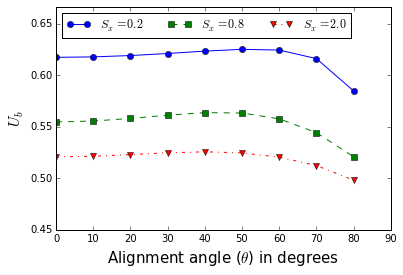

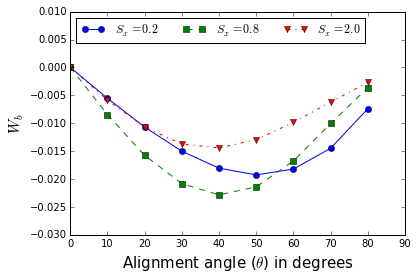

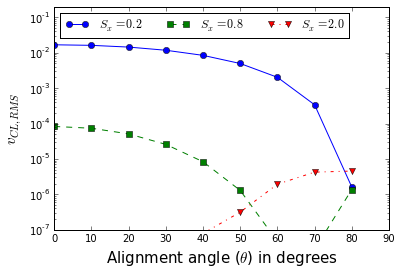

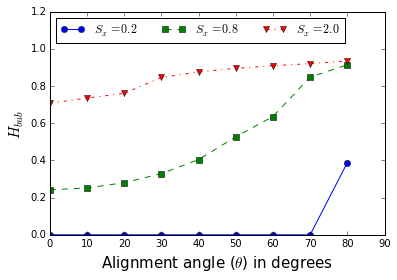

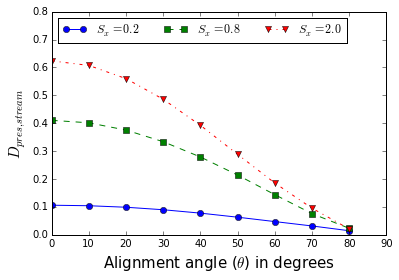

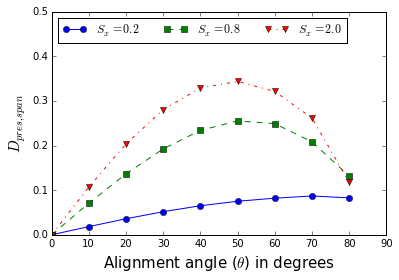

In [36]:
markers=['-o','--s','-.v']

fName = 'uBulkObliqueLine.eps'
ylims = [0.45,2./3.]; ylab = '$U_b$'
plt.figure()
for k in range(3):
    plt.plot(thetaArr*180./np.pi, Ub2D[:,k],markers[k],)
plt.xlim([0.,90.]); plt.ylim(ylims)
plt.legend(['$S_x = 0.2$','$S_x = 0.8$','$S_x = 2.0$'],loc=2,ncol=3)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('Alignment angle ($\\theta$) in degrees',fontsize=15)
plt.ylabel(ylab,fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

fName = 'wBulkObliqueLine.eps'
ylims = [-0.03,0.01]; ylab = '$W_b$'
plt.figure()
for k in range(3):
    plt.plot(thetaArr*180./np.pi, Wb2D[:,k],markers[k],)
plt.xlim([0.,90.]); plt.ylim(ylims)
plt.legend(['$S_x = 0.2$','$S_x = 0.8$','$S_x = 2.0$'],loc=2,ncol=3)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('Alignment angle ($\\theta$) in degrees',fontsize=15)
plt.ylabel(ylab,fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()


fName = 'vCoreObliqueLine.eps'
ylims = [1.0e-07,2.0e-01]; ylab = '$v_{CL,RMS}$'
plt.figure()
for k in range(3):
    plt.plot(thetaArr*180./np.pi, vCore2D[:,k],markers[k],)
plt.xlim([0.,90.]); plt.ylim(ylims)
plt.yscale('log')
plt.legend(['$S_x = 0.2$','$S_x = 0.8$','$S_x = 2.0$'],loc=2,ncol=3)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('Alignment angle ($\\theta$) in degrees',fontsize=15)
plt.ylabel(ylab,fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()


fName = 'yBubObliqueLine.eps'
ylims = [0.,1.2]; ylab = '$H_{bub}$'
plt.figure()
for k in range(3):
    plt.plot(thetaArr*180./np.pi, yBub2D[:,k],markers[k],)
plt.xlim([0.,90.]); plt.ylim(ylims)
plt.legend(['$S_x = 0.2$','$S_x = 0.8$','$S_x = 2.0$'],loc=2,ncol=3)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('Alignment angle ($\\theta$) in degrees',fontsize=15)
plt.ylabel(ylab,fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

fName = 'pDragObliqueLine.eps'
ylims = [0.,0.8]; ylab = '$D_{pres,stream}$'
plt.figure()
for k in range(3):
    plt.plot(thetaArr*180./np.pi, pDX2D[:,k],markers[k],)
plt.xlim([0.,90.]); plt.ylim(ylims)
plt.legend(['$S_x = 0.2$','$S_x = 0.8$','$S_x = 2.0$'],loc=2,ncol=3)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('Alignment angle ($\\theta$) in degrees',fontsize=15)
plt.ylabel(ylab,fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()

fName = 'pDragZObliqueLine.eps'
ylims = [0.,0.5]; ylab = '$D_{pres, span}$'
plt.figure()
for k in range(3):
    plt.plot(thetaArr*180./np.pi, pDZ2D[:,k],markers[k],)
plt.xlim([0.,90.])
plt.ylim(ylims)
plt.legend(['$S_x = 0.2$','$S_x = 0.8$','$S_x = 2.0$'],loc=2,ncol=3)
plt.savefig(figureFolder+'noLabels/'+fName,format='eps',dpi=1200)
plt.xlabel('Alignment angle ($\\theta$) in degrees',fontsize=15)
plt.ylabel(ylab,fontsize=15)
plt.savefig(figureFolder+fName,format='eps',dpi=1200)
plt.show()



In [43]:
Ub2D

array([[ 0.61742063,  0.55465741,  0.52083359],
       [ 0.61828497,  0.55643703,  0.52197436],
       [ 0.62039119,  0.56017817,  0.52417771],
       [ 0.62272353,  0.56315634,  0.52556669],
       [ 0.62447582,  0.56405118,  0.52550422],
       [ 0.62531507,  0.56297839,  0.52430068],
       [ 0.62523843,  0.56058219,  0.52245564],
       [ 0.62438066,  0.55747739,  0.52034439],
       [ 0.62290498,  0.55409149,  0.51818852],
       [ 0.62096075,  0.55068037,  0.51610156],
       [ 0.61867282,  0.54738246,  0.51413348],
       [ 0.6161421 ,  0.54426493,  0.51230022],
       [ 0.61344912,  0.5413543 ,  0.51060081],
       [ 0.61065753,  0.53865478,  0.50902672],
       [ 0.60781719,  0.53615896,  0.50756661],
       [ 0.65609198,  0.60667172,  0.55561159]])

In [48]:
vf,pf = loadff('solutions/thetaDep/T90E0500Gx0000Gz0100Re0100L00M06N50.npy')

In [49]:
vf.flux()

array([ 0.65609198])

#RIBLETS

## Running for Riblet solns

In [ ]:
savePath = 'solutions/T90/slopeDep/'
Re=100.
flowDict = getDefaultDict()
flowDict.update({'eps':0.01,'beta':10.,'alpha':0.,'Re':Re,'isPois':1,'L':0,'M':8,'N':50})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()

epsArr = 0.5*np.array([0.1,0.2])
gzArr = 0.5*np.concatenate(([np.arange(0.25,5.001,0.25),np.arange(6.,19.1)])).flatten()
print(gzArr.shape, gzArr.size)
for k1 in range(epsArr.size):
    eps = round(epsArr[k1],4)
    vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
    for k2 in range(gzArr.size):
        gz = round(gzArr[k2],3)
        b = gz/eps
        vf.flowDict.update({'beta':b}); pf.flowDict.update({'beta':b})
        print('eps, gz,Re:',eps,gz,Re)
        start1 = time.time()
        vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=6,tol=1.0e-11)
        saveff(vf,pf,prefix=savePath)
        print("Runtime:",np.int(time.time()-start1))
        sys.stdout.flush()


In [4]:
np.arange(0.01,0.201,0.01)

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ])

## Riblets 

In [48]:
vfHigh,pfHigh = loadff('solutions/T90/Re100/T90E0500Gx0000Gz1500Re0100L00M06N50.npy')
vfMid,pfMid = loadff('solutions/T90/Re100/T90E0500Gx0000Gz0750Re0100L00M06N50.npy')
vfLow,pfLow = loadff('solutions/T90/Re100/T90E0500Gx0000Gz0250Re0100L00M06N50.npy')

eps: 0.05


/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


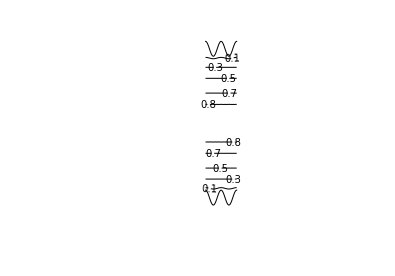

In [50]:
vf = vfHigh; fName = 'uContoursRibletHigh'

uLevels = np.array([0.1,0.3,0.5,0.7,0.8,0.9])
nz = 40

b = vf.flowDict['beta']; Lz = 2.*np.pi/b
eps = vf.flowDict['eps']; print('eps:',eps)
Z = np.tile( np.arange(0.,2.0001*Lz, Lz/nz).reshape((1,2*nz+1)), (vf.N,1))
Y = vf.y.reshape((vf.N,1)) + 2.*eps*np.cos(b*Z)

#figWidth = 2*Lx+2 # Extra inch for the colorbar
U = vf.getScalar().getPhysical(zLoc=Z[0]).reshape((Z.shape[1],vf.N)).T
V = vf.getScalar(nd=1).getPhysical(zLoc=Z[0]).reshape((Z.shape[1],vf.N)).T


#plt.figure(figsize=(figWidth,figHeight))
plt.figure()
plt.plot(Z[0],Y[0],'k')
plt.plot(Z[-1],Y[-1],'k')

# Line contours for U
uctr = plt.contour(Z,Y,U, colors='k', levels = uLevels)
plt.clabel(uctr,fmt='%0.1f',fontsize='x-large')
plt.ylim([-1.15,1.15])
plt.axis('off')
plt.axis('equal')
plt.xlabel('z',fontsize=15); plt.ylabel('y',fontsize=15)
plt.margins(x=0)
#plt.text(Lz,-1.3,'z',fontsize=15)
#plt.text(-0.2,0,'y',fontsize=15)
ax = plt.gca()
#ax.annotate('z',xy = (2*Lz,-1.25), xytext=(Lz,-1.25),xycoords = 'data', textcoords='data', arrowprops=dict(facecolor='black'))

plt.savefig(figureFolder+fName+'.eps',dpi=1200,format='eps')
plt.show()


## Low wavenumber asymptote

In [ ]:
Re=100.
flowDict = getDefaultDict()
flowDict.update({'eps':0.01,'beta':1.,'alpha':0.,'Re':Re,'isPois':1,'L':0,'M':4,'N':10})
vf = dict2ff(flowDict)
pf = vf.getScalar().zero()
vfList = []; pfList = []

epsArr = 0.5*np.arange(0.025,0.1501,0.025)
bArr = 10.**(np.arange(-2.,2.001,0.25))

for k1 in range(epsArr.size):
    eps = epsArr[k1]
    vf.flowDict.update({'eps':eps}); pf.flowDict.update({'eps':eps})
    for k2 in range(bArr.size):
        b = bArr[k2]
        vf.flowDict.update({'beta':b}); pf.flowDict.update({'beta':b})
        print('eps, b,Re:',eps,b,Re)
        start1 = time.time()
        vf, pf, fnorm, flg = iterate(vf=vf, pf=pf, iterMax=6,tol=1.0e-13)
        #print("res norm:%.3g"%(vf.residuals(pField=pf).norm()))
        vfList.append(vf); pfList.append(pf)
        #print("Runtime:",np.int(time.time()-start1))
        sys.stdout.flush()


In [4]:
uBulkArr = np.zeros((epsArr.size,bArr.size))
k = 0
for k1 in range(epsArr.size):
    for k2 in range(bArr.size):
        vf = vfList[k]; pf = pfList[k]
        uBulkArr[k1,k2] = vf.flux()
        k+= 1

#uBulkArr = uBulkArr[:6]

['Analytical', 'A=0.025', '0.05', '0.075', '0.1', '0.125', '0.15']


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


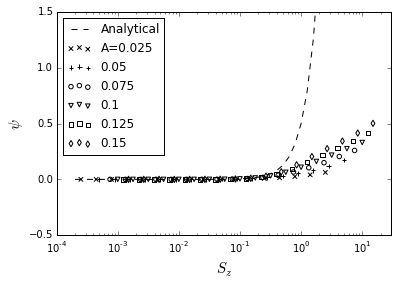

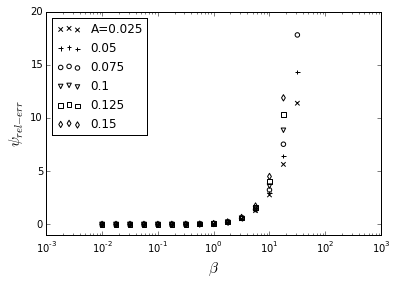

In [13]:
markers = ['x','+','o','v','s','d']

plt.figure()
plt.xscale("log")
leg = []

gzTemp = 10.**np.arange(-4.,2.,0.1)
plt.plot(2.*gzTemp, 2.*gzTemp**2,'k--'); leg.append('Analytical')
for k1 in range(epsArr.size):
    gzArr = epsArr[k1]*bArr
    psi = (1.-3./2.*uBulkArr[k1])
    plt.scatter(2.*gzArr,  psi , marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))


plt.ylim([-0.5,1.5])    
leg[1] = 'A='+leg[1]
print(leg)
plt.legend(leg,loc=2)
plt.xlim([0.0001,30.])
plt.savefig(figureFolder+'noLabels/'+'psiRiblet.eps',format='eps',dpi=1200)
plt.xlabel('$S_z$',fontsize=15); plt.ylabel('$\\psi$',fontsize=15)
plt.savefig(figureFolder+'psiRiblet.eps',format='eps',dpi=1200)
plt.show()



plt.figure()
plt.xscale("log")
leg = []

for k1 in range(epsArr.size):
    gzArr = epsArr[k1]*bArr
    psi = (1.-3./2.*uBulkArr[k1])
    plt.scatter(bArr,  (2.*gzArr**2 - psi)/psi, marker=markers[k1],color='k',facecolors='none')
    leg.append(str(2.*epsArr[k1]))

leg[0] = 'A='+leg[0]
plt.legend(leg,loc=2)
plt.ylim([-1.,20.])
plt.savefig(figureFolder+'noLabels/'+'psiRelErrRiblet.eps',format='eps',dpi=1200)
plt.xlabel('$\\beta$',fontsize=15); plt.ylabel('$\\psi_{rel-err}$',fontsize=15)
plt.savefig(figureFolder+'psiRelErrRiblet.eps',format='eps',dpi=1200)
plt.show()

## Riblets: High wavenumber asymptote

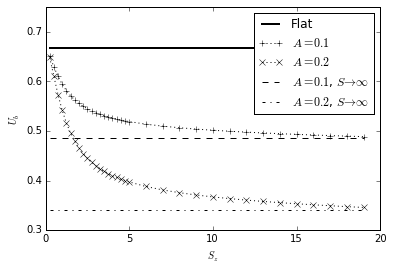

In [28]:
fName = 'highSlopeAsymRiblet.eps'
vfList = []; pfList = []
loadPath = 'solutions/T90/slopeDep/'
files = os.listdir(loadPath)
files.sort()
for f in files:
    vf, pf = loadff(loadPath+f)
    vfList.append(vf.copy())
    pfList.append(pf.copy())
vfArr = flowFieldArray(vfList, 2,len(vfList)//2,1)
pfArr = flowFieldArray(pfList, 2,len(vfList)//2,1)

uBulkArr = vfArr.getProperty('flux')
epsArr = vfArr.getProperty('eps')
gzArr = vfArr.getProperty('eps')*vfArr.getProperty('b')
gzVec = gzArr[0,:,0]

plt.plot(2.*gzVec, 2./3.*np.ones(gzVec.size),'k',linewidth=2 )
plt.plot(2.*gzVec,uBulkArr[0,:,0],'k:+') # Re=1000
plt.plot(2.*gzVec,uBulkArr[1,:,0],'k:x') # Re=1000
plt.plot(2.*gzVec, 2./3.*((1.-2.*epsArr[0,0,0])**3)*np.ones(gzVec.size) ,'k--')
plt.plot(2.*gzVec, 2./3.*((1.-2.*epsArr[1,0,0])**3)*np.ones(gzVec.size) ,'k-.')
plt.legend(['Flat', '$A=0.1$','$A=0.2$','$A=0.1$, $S \\to \\infty$', '$A=0.2$, $S \\to \\infty$'],loc='upper right')
#uBulkAsym = 2./3.*(1.-2.*tempDict['eps'])**2
plt.ylim([0.3,0.75])
plt.xlabel('$S_z$'); plt.ylabel('$U_b$')
#plt.title('Bulk velocity for Amplitude A=%.2g'%(epsArr[eInd,0,0]) )
plt.savefig(figureFolder+fName,dpi=1200,format='eps')
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


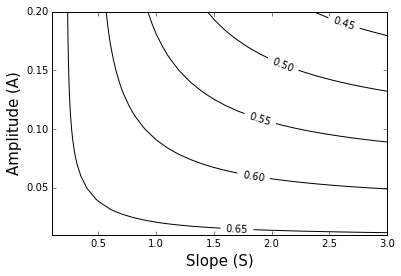

In [34]:
fName = 'fluxRiblet.eps'
vfList = []; pfList = []
loadPath = 'solutions/T90/Re100/'
files = os.listdir(loadPath)
files.sort()
for f in files:
    vf, pf = loadff(loadPath+f)
    vfList.append(vf.copy())
    pfList.append(pf.copy())
vfArr = flowFieldArray(vfList, 20,len(vfList)//20,1)
pfArr = flowFieldArray(pfList, 20,len(vfList)//20,1)

uBulkArr = vfArr.getProperty('flux')
epsArr = vfArr.getProperty('eps')
gzArr = vfArr.getProperty('eps')*vfArr.getProperty('b')
gzVec = gzArr[0,:,0]

plt.figure()
# vFlux-yBub
C10 = plt.contour(2.*gzArr[0,:,0], 2.*epsArr[:,0,0], uBulkArr[:,:,0],levels = np.arange(0.4,0.66,0.05),colors='k')
plt.clabel(C10,fmt='%0.2f',fontsize='x-large')
plt.savefig(figureFolder+'noLabels/'+fName,dpi=1200,format="eps")
plt.xlabel("Slope (S)",fontsize=15); plt.ylabel("Amplitude (A)",fontsize=15)
plt.savefig(figureFolder+fName,dpi=1200,format="eps")
plt.show()


In [10]:
180./np.pi*np.arctan(np.arange(0.,4.0001,0.25))

array([  0.        ,  14.03624347,  26.56505118,  36.86989765,
        45.        ,  51.34019175,  56.30993247,  60.2551187 ,
        63.43494882,  66.03751103,  68.19859051,  70.01689348,
        71.56505118,  72.89727103,  74.0546041 ,  75.06858282,  75.96375653])

In [9]:
np.tan(np.pi/180.*75)

3.7320508075688776